# Estrous Cycle Detection via Ultradian Power Analysis

## Report Section: Wavelet Analysis of Locomotor Activity

### Purpose
This notebook implements wavelet-based estrous cycle detection following the methodology of Smarr et al. (2017). The key insight from their work is that **estrus days show suppressed ultradian (1-3 hour) power** in activity rhythms due to prolonged activity plateaus rather than the typical oscillatory pattern.

### Outline
1. **Smarr Figure Recreation** - Validate the wavelet method using Smarr's ground-truth data
2. **Negative Control** - Confirm that shuffled estrus labels show no effect
3. **Morph2REP Analysis** - Apply the method to detect estrous cycling in our data

### Data Sources
- **Smarr 2017 Data**: Female BALB/c mice with implanted Minimitter G2 telemetry (locomotor activity counts, 1-min resolution, 8 days, estrus = Day 1)
- **Morph2REP Data**: Female strain 664 mice from Study 1001, vehicle-treated cages only

### Why Locomotion Bouts?
Smarr's Minimitter G2 implants contain an **accelerometer** that detects physical movement/displacement. From the available Morph2REP metrics:

| Metric | Description | Analogy to Smarr |
|--------|-------------|------------------|
| `animal.distance_travelled` | Continuous distance (cm/s) | Indirect |
| `animal_bouts.active` | Any active state (includes grooming, eating) | Broader |
| `animal_bouts.locomotion` | Specifically movement bouts | **Best match** |

We use **`animal_bouts.locomotion`** as it most closely matches Smarr's accelerometer-based locomotor activity measure.

---
## Section 1: Setup and Data Loading

In [1]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
from datetime import date
from scipy.signal import cwt, morlet2
from scipy.stats import wilcoxon, chisquare
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10

# Constants
MINUTES_PER_DAY = 1440
PERIODS_MINUTES = np.logspace(np.log10(60), np.log10(39*60), 50)  # 1h to 39h
PERIODS_HOURS = PERIODS_MINUTES / 60

print("Setup complete.")
print(f"  Period range: {PERIODS_HOURS.min():.1f}h to {PERIODS_HOURS.max():.1f}h")
print(f"  Ultradian band: 1-3 hours")

Setup complete.
  Period range: 1.0h to 39.0h
  Ultradian band: 1-3 hours


In [2]:
# =============================================================================
# WAVELET FUNCTIONS
# =============================================================================

def compute_wavelet_transform(data, periods_minutes=None, w=5):
    """
    Compute continuous wavelet transform using Morlet wavelet.
    
    Parameters:
    -----------
    data : 1D array - time series (1-min resolution)
    periods_minutes : array - periods to analyze (in minutes)
    w : int - Morlet wavelet parameter (similar to Smarr's Morse β=5)
    
    Returns:
    --------
    power : 2D array - (n_periods, n_timepoints)
    periods : array - periods analyzed (in minutes)
    """
    # Handle NaNs
    data = pd.Series(data).interpolate().bfill().ffill().fillna(0).values
    
    if periods_minutes is None:
        periods_minutes = PERIODS_MINUTES
    
    # Convert periods to scales for morlet2 wavelet
    fs = 1  # 1 sample per minute
    scales = periods_minutes * fs * w / (2 * np.pi)
    
    # Compute CWT
    coeffs = cwt(data, morlet2, scales, w=w)
    power = np.abs(coeffs)**2
    
    return power, periods_minutes


def extract_band_power(power, periods_minutes, band_hours):
    """
    Extract MAX power in a frequency band (per Smarr's methods).
    
    Parameters:
    -----------
    power : 2D array - (n_periods, n_timepoints)
    periods_minutes : array - periods in minutes
    band_hours : tuple - (min_hours, max_hours)
    
    Returns:
    --------
    band_power : 1D array - max power in band at each timepoint
    """
    periods_hours = periods_minutes / 60
    band_mask = (periods_hours >= band_hours[0]) & (periods_hours <= band_hours[1])
    
    if not np.any(band_mask):
        return np.zeros(power.shape[1])
    
    # MAX power in band (as per Smarr's methods)
    band_power = np.max(power[band_mask, :], axis=0)
    
    return band_power


print("Wavelet functions defined.")

Wavelet functions defined.


### 1.1 Load Smarr 2017 Data

Ground-truth dataset from Smarr et al. (2017) "Sex differences in variability across timescales in BALB/c mice" (Biology of Sex Differences).

- 14 female BALB/c mice
- Implanted Minimitter G2 telemetry
- 1-minute resolution locomotor activity
- **Day 1 = Estrus** (confirmed via CBT plateau detection)

In [3]:
# =============================================================================
# LOAD SMARR DATA
# =============================================================================
print("Loading Smarr 2017 Data...")

df_smarr = pd.read_csv('mice data.xlsx - FemAct (1).csv')

female_cols = [col for col in df_smarr.columns if col.startswith('fem')]
female_data = df_smarr[female_cols].values.T  # (n_females, n_timepoints)

n_females, n_timepoints = female_data.shape

print(f"\nSMARR 2017 DATASET:")
print(f"  N females: {n_females}")
print(f"  Timepoints: {n_timepoints:,} minutes ({n_timepoints/MINUTES_PER_DAY:.1f} days)")
print(f"  Resolution: 1 minute")
print(f"  Estrus: Day 1 (ground truth from CBT plateau detection)")

Loading Smarr 2017 Data...

SMARR 2017 DATASET:
  N females: 14
  Timepoints: 11,520 minutes (8.0 days)
  Resolution: 1 minute
  Estrus: Day 1 (ground truth from CBT plateau detection)


In [5]:
# =============================================================================
# LOAD SMARR DATA
# =============================================================================
print("Loading Smarr 2017 Data...")

df_smarr = pd.read_csv('mice data.xlsx - MaleAct (1).csv')

male_cols = [col for col in df_smarr.columns if col.startswith('male')]
male_data = df_smarr[male_cols].values.T  # (n_

n_males, n_timepoints = male_data.shape

print(f"\nSMARR 2017 DATASET:")
print(f"  N males: {n_males}")
print(f"  Timepoints: {n_timepoints:,} minutes ({n_timepoints/MINUTES_PER_DAY:.1f} days)")
print(f"  Resolution: 1 minute")
print(f"  Estrus: Day 1 (ground truth from CBT plateau detection)")

Loading Smarr 2017 Data...

SMARR 2017 DATASET:
  N males: 6
  Timepoints: 11,520 minutes (8.0 days)
  Resolution: 1 minute
  Estrus: Day 1 (ground truth from CBT plateau detection)


### 1.2 Load Morph2REP Data

**Study 1001** - Morphine treatment study with female strain 664 mice.

We analyze only **vehicle-treated cages** to establish baseline estrous patterns:
- **Rep1**: Cages 4918, 4922, 4923 (Jan 10-22, 2025)
- **Rep2**: Cages 4928, 4929, 4934 (Jan 25 - Feb 4, 2025)

Data source: `animal_bouts.parquet` → filtered for `animal_bouts.locomotion`

In [4]:
# =============================================================================
# MORPH2REP CONFIGURATION
# =============================================================================
S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

VEHICLE_CAGES = {
    "Rep1": {
        "cages": [4918, 4922, 4923],
        "analysis_start": "2025-01-10",
        "analysis_end": "2025-01-22",
        "n_days": 12,
    },
    "Rep2": {
        "cages": [4928, 4929, 4934],
        "analysis_start": "2025-01-25",
        "analysis_end": "2025-02-04",
        "n_days": 10,
    },
}

def load_parquet_s3(cage_id, start_date, end_date, table_name):
    """Load parquet data from S3 for a specific cage and date range."""
    conn = duckdb.connect()
    conn.execute("INSTALL httpfs; LOAD httpfs;")
    conn.execute("SET s3_region='us-east-1';")
    
    dates = pd.date_range(start_date, end_date, freq='D')
    all_data = []
    
    for d in dates:
        date_str = d.strftime('%Y-%m-%d')
        path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{table_name}"
        try:
            df = conn.execute(f"SELECT * FROM read_parquet('{path}')").fetchdf()
            df['cage_id'] = cage_id
            df['date'] = date_str
            all_data.append(df)
        except:
            continue
    
    conn.close()
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

print("Configuration complete.")

Configuration complete.


In [5]:
# =============================================================================
# LOAD LOCOMOTION BOUT DATA
# =============================================================================
print("Loading Morph2REP Locomotion Bout Data...")
print("="*60)

all_bouts = []
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    for cage_id in cfg['cages']:
        print(f"  Cage {cage_id}...", end=" ")
        df = load_parquet_s3(cage_id, cfg['analysis_start'], cfg['analysis_end'], 'animal_bouts.parquet')
        if len(df) > 0:
            df['replicate'] = rep
            all_bouts.append(df)
            print(f"{len(df):,} rows")
        else:
            print("No data")

df_bouts = pd.concat(all_bouts, ignore_index=True)
print(f"\nTotal bout rows: {len(df_bouts):,}")

# Show available bout types
print(f"\nBout types available:")
print(df_bouts['state_name'].value_counts())

Loading Morph2REP Locomotion Bout Data...

Rep1:
  Cage 4918... 2,201,519 rows
  Cage 4922... 2,039,081 rows
  Cage 4923... 2,117,667 rows

Rep2:
  Cage 4928... 1,872,654 rows
  Cage 4929... 1,688,050 rows
  Cage 4934... 1,795,480 rows

Total bout rows: 11,714,451

Bout types available:
state_name
animal_bouts.social.in_proximity_other    4228593
animal_bouts.social.isolated_other        2674221
animal_bouts.active                       1340775
animal_bouts.social.proximal_all          1063945
animal_bouts.inactive                      939711
animal_bouts.social.isolated_all           621258
animal_bouts.locomotion                    457610
animal_bouts.climbing                      178953
animal_bouts.feeding                       158279
animal_bouts.inferred_sleep                 32415
animal_bouts.drinking                       18691
Name: count, dtype: int64


In [6]:
# =============================================================================
# FILTER FOR LOCOMOTION BOUTS
# =============================================================================
df_loco = df_bouts[df_bouts['state_name'] == 'animal_bouts.locomotion'].copy()
df_loco['start_time'] = pd.to_datetime(df_loco['start_time'])

print(f"Locomotion bouts: {len(df_loco):,}")
for rep in ['Rep1', 'Rep2']:
    rep_df = df_loco[df_loco['replicate'] == rep]
    print(f"  {rep}: {len(rep_df):,} bouts, {rep_df['animal_id'].nunique()} animals")

Locomotion bouts: 457,610
  Rep1: 246,975 bouts, 9 animals
  Rep2: 210,635 bouts, 9 animals


---
## Section 2: Smarr Figure 2 Recreation

We recreate key panels from Smarr et al. (2017) Figure 2 to validate our wavelet implementation:

- **Figure 2a**: Wavelet spectrogram showing power across frequencies (1-39h) over 4 days
- **Figure 2h**: Ultradian (1-3h) power time series showing the dip on estrus day

**Expected result**: Ultradian power should be significantly LOWER on Day 1 (estrus) compared to Days 2-4.

In [6]:
# =============================================================================
# COMPUTE WAVELET TRANSFORMS FOR SMARR DATA
# =============================================================================
print("Computing wavelet transforms for Smarr males...")

all_spectrograms = []
all_ultradian = []

for i in range(n_males):
    power, _ = compute_wavelet_transform(male_data[i, :], PERIODS_MINUTES)
    all_spectrograms.append(power)
    ultradian = extract_band_power(power, PERIODS_MINUTES, (1, 3))
    all_ultradian.append(ultradian)

all_spectrograms = np.array(all_spectrograms)
all_ultradian = np.array(all_ultradian)

print(f"  Done. Spectrogram shape: {all_spectrograms.shape}")

Computing wavelet transforms for Smarr females...
  Done. Spectrogram shape: (6, 50, 11520)


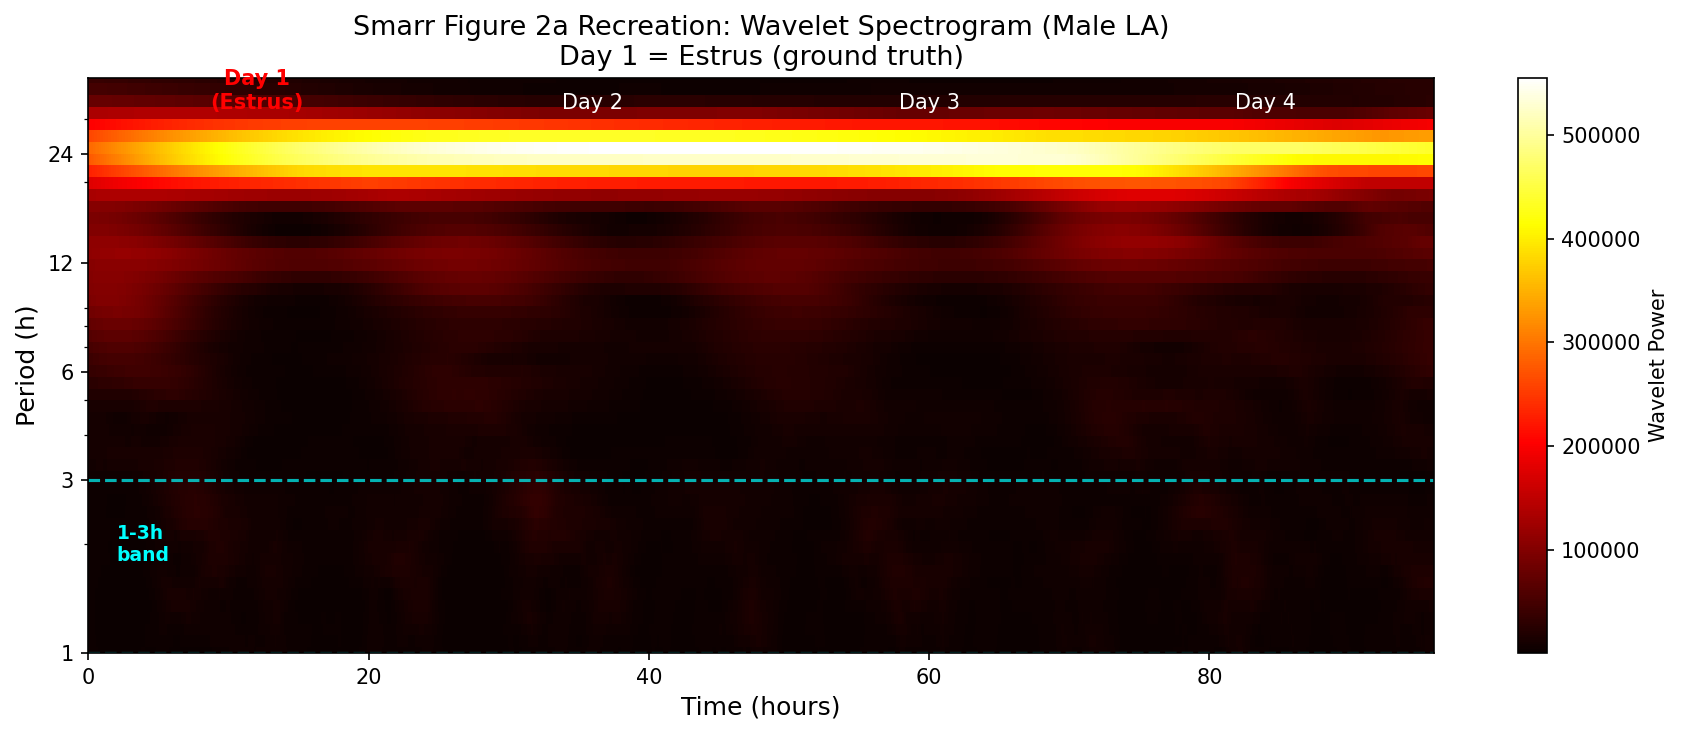

In [7]:
# =============================================================================
# FIGURE 2A: WAVELET SPECTROGRAM
# =============================================================================
n_minutes_4days = 4 * MINUTES_PER_DAY
median_spectrogram = np.median(all_spectrograms[:, :, :n_minutes_4days], axis=0)

fig, ax = plt.subplots(figsize=(12, 5))
time_hours = np.arange(n_minutes_4days) / 60

im = ax.pcolormesh(time_hours, PERIODS_HOURS, median_spectrogram, 
                   shading='auto', cmap='hot')

ax.set_yscale('log')
ax.set_ylabel('Period (h)', fontsize=12)
ax.set_xlabel('Time (hours)', fontsize=12)
ax.set_title('Smarr Figure 2a Recreation: Wavelet Spectrogram (Male LA)\nDay 1 = Estrus (ground truth)', fontsize=13)

ax.set_yticks([1, 3, 6, 12, 24])
ax.set_yticklabels(['1', '3', '6', '12', '24'])
ax.set_ylim(1, 39)
ax.set_xlim(0, 96)

# Mark ultradian band
ax.axhline(y=1, color='cyan', linestyle='--', alpha=0.7)
ax.axhline(y=3, color='cyan', linestyle='--', alpha=0.7)
ax.text(2, 1.8, '1-3h\nband', color='cyan', fontsize=9, fontweight='bold')

# Day labels
for day in range(1, 5):
    color = 'red' if day == 1 else 'white'
    weight = 'bold' if day == 1 else 'normal'
    label = f'Day {day}\n(Estrus)' if day == 1 else f'Day {day}'
    ax.text((day - 0.5) * 24, 32, label, ha='center', fontsize=10, color=color, fontweight=weight)

plt.colorbar(im, ax=ax, label='Wavelet Power')
plt.tight_layout()
plt.savefig('smarr_fig2a_spectrogram.png', dpi=150, bbox_inches='tight')
plt.show()

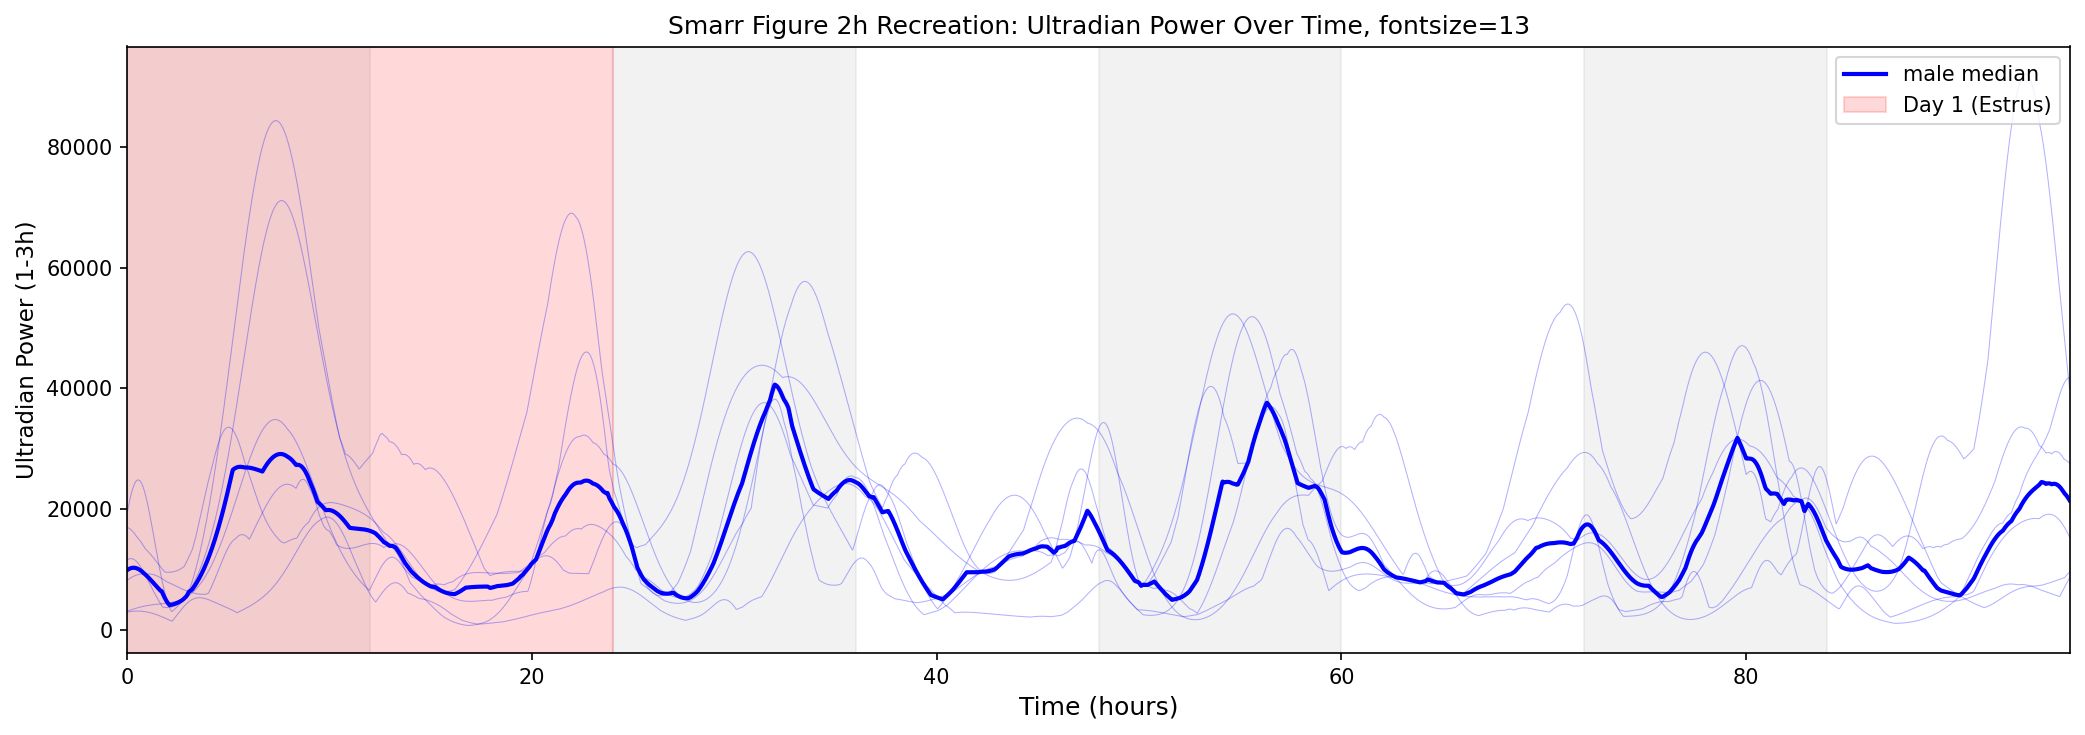

In [11]:
# =============================================================================
# FIGURE 2H: ULTRADIAN POWER OVER TIME
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 5))
time_hours_4day = np.arange(n_minutes_4days) / 60

# Individual traces (thin lines)
for i in range(n_males):
    ax.plot(time_hours_4day, all_ultradian[i, :n_minutes_4days], 
            color='blue', alpha=0.3, linewidth=0.5)

# Median (thick line)
median_ultradian = np.median(all_ultradian[:, :n_minutes_4days], axis=0)
ax.plot(time_hours_4day, median_ultradian, color='blue', linewidth=2, label='male median')

# Light/dark shading (dark = first 12h of each day)
for day in range(4):
    ax.axvspan(day*24, day*24 + 12, alpha=0.1, color='gray')

# Mark estrus day
ax.axvspan(0, 24, alpha=0.15, color='red', label='Day 1 (Estrus)')

ax.set_xlabel('Time (hours)', fontsize=12)
ax.set_ylabel('Ultradian Power (1-3h)', fontsize=11)
ax.set_title('Smarr Figure 2h Recreation: Ultradian Power Over Time, fontsize=13')
ax.legend(loc='upper right')
ax.set_xlim(0, 96)

plt.tight_layout()
plt.savefig('smarr_fig2h_ultradian.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# =============================================================================
# QUANTIFY: ESTRUS VS NON-ESTRUS ULTRADIAN POWER
# =============================================================================
print("="*60)
print("SMARR: Estrus vs Non-Estrus Ultradian Power")
print("="*60)

# Day 1 (estrus): minutes 0-1440
# Days 2-4 (non-estrus): minutes 1440-5760
estrus_ur = all_ultradian[:, :MINUTES_PER_DAY].mean(axis=1)
non_estrus_ur = all_ultradian[:, MINUTES_PER_DAY:4*MINUTES_PER_DAY].mean(axis=1)

print(f"\n{'Mouse':<10} {'Estrus (D1)':<15} {'Non-E (D2-4)':<15} {'Ratio':<10} {'Lower?'}")
print("-"*60)

for i, col in enumerate(female_cols):
    ratio = estrus_ur[i] / non_estrus_ur[i]
    lower = "✓" if ratio < 1 else "✗"
    print(f"{col:<10} {estrus_ur[i]:<15.1f} {non_estrus_ur[i]:<15.1f} {ratio:<10.2f} {lower}")

n_lower = np.sum(estrus_ur < non_estrus_ur)
stat, p_wilcox = wilcoxon(estrus_ur, non_estrus_ur)

print("-"*60)
print(f"Mice with LOWER power on estrus: {n_lower}/{n_females} ({100*n_lower/n_females:.0f}%)")
print(f"\nStatistical test:")
print(f"  Wilcoxon signed-rank: p = {p_wilcox:.4f}")
print(f"\nMean ± SD:")
print(f"  Estrus: {estrus_ur.mean():.1f} ± {estrus_ur.std():.1f}")
print(f"  Non-estrus: {non_estrus_ur.mean():.1f} ± {non_estrus_ur.std():.1f}")
print(f"  Ratio: {estrus_ur.mean() / non_estrus_ur.mean():.2f}")

print(f"\n{'✓ METHOD VALIDATED' if p_wilcox < 0.05 else '✗ METHOD NOT VALIDATED'}")

SMARR: Estrus vs Non-Estrus Ultradian Power

Mouse      Estrus (D1)     Non-E (D2-4)    Ratio      Lower?
------------------------------------------------------------
fem1       3491.3          4377.1          0.80       ✓
fem2       7062.5          9395.8          0.75       ✓
fem3       7413.8          10578.6         0.70       ✓
fem4       6925.3          17422.5         0.40       ✓
fem5       5645.8          7832.7          0.72       ✓
fem6       2882.1          7945.1          0.36       ✓
fem7       3485.3          6398.3          0.54       ✓
fem8       9455.5          9674.9          0.98       ✓
fem9       23467.5         21012.3         1.12       ✗
fem10      6417.8          11277.2         0.57       ✓
fem11      7977.8          12211.9         0.65       ✓
fem12      9255.8          14539.7         0.64       ✓
fem13      4843.7          8095.8          0.60       ✓
fem14      8037.8          7991.8          1.01       ✗
-------------------------------------------------

In [12]:
import numpy as np
from scipy.stats import wilcoxon

rng = np.random.default_rng(42)

n_days = 4
minutes_per_day = MINUTES_PER_DAY

def day_mean_ultradian(ultradian_ts, day_idx):
    start = day_idx * minutes_per_day
    end = (day_idx + 1) * minutes_per_day
    return ultradian_ts[start:end].mean()

B = 1000
pvals = []
ratios = []

for _ in range(B):
    fake_day = rng.integers(0, n_days)  # 0..3
    fake = np.array([day_mean_ultradian(all_ultradian[i], fake_day) for i in range(n_males)])

    others = []
    for i in range(n_males):
        other_days = [d for d in range(n_days) if d != fake_day]
        others.append(np.mean([day_mean_ultradian(all_ultradian[i], d) for d in other_days]))
    others = np.array(others)

    # paired test across males
    stat, p = wilcoxon(fake, others, alternative="two-sided")
    pvals.append(p)
    ratios.append(fake.mean() / others.mean())

pvals = np.array(pvals)
ratios = np.array(ratios)

print("Random fake-day negative control:")
print(f"  median p-value: {np.median(pvals):.3f} (should be ~0.5)")
print(f"  fraction p<0.05: {(pvals < 0.05).mean():.3f} (should be ~0.05)")
print(f"  mean ratio (fake/others): {ratios.mean():.3f} (should be ~1)")
print(f"  ratio std: {ratios.std():.3f}")


Random fake-day negative control:
  median p-value: 1.000 (should be ~0.5)
  fraction p<0.05: 0.000 (should be ~0.05)
  mean ratio (fake/others): 1.000 (should be ~1)
  ratio std: 0.066


In [14]:
B = 1000
pvals = []
ratios = []
rng = np.random.default_rng(42)

for _ in range(B):
    fake_days = rng.integers(0, 4, size=n_males)  # one fake day per male
    fake = np.array([day_mean_ultradian(all_ultradian[i], fake_days[i]) for i in range(n_males)])

    others = []
    for i in range(n_males):
        other_days = [d for d in range(4) if d != fake_days[i]]
        others.append(np.mean([day_mean_ultradian(all_ultradian[i], d) for d in other_days]))
    others = np.array(others)

    stat, p = wilcoxon(fake, others)
    pvals.append(p)
    ratios.append(fake.mean() / others.mean())

print("median p:", np.median(pvals))
print("frac p<0.05:", np.mean(np.array(pvals) < 0.05))
print("mean ratio:", np.mean(ratios))
print("ratio std:", np.std(ratios))


median p: 0.5625
frac p<0.05: 0.028
mean ratio: 1.0001501521556608
ratio std: 0.123295411295675


---
## Section 3: Negative Control

To confirm the observed effect is real (not a statistical artifact), we perform a **permutation test**:

1. Randomly shuffle "estrus" day labels 1000 times
2. Calculate the estrus vs non-estrus difference for each permutation
3. Compare the observed difference to the null distribution

**Expected result**: The observed difference should be significantly larger than random (p < 0.05).

In [11]:
# =============================================================================
# NEGATIVE CONTROL: PERMUTATION TEST
# =============================================================================
print("="*60)
print("NEGATIVE CONTROL: Permutation Test")
print("="*60)

np.random.seed(42)
n_permutations = 1000

# Observed difference (non-estrus - estrus, should be positive if method works)
observed_diff = non_estrus_ur.mean() - estrus_ur.mean()

# Generate null distribution
perm_diffs = []
for _ in range(n_permutations):
    shuffled_estrus = []
    shuffled_non_estrus = []
    
    for i in range(n_females):
        # Get all 4 days of power for this animal
        day_powers = [all_ultradian[i, d*MINUTES_PER_DAY:(d+1)*MINUTES_PER_DAY].mean() for d in range(4)]
        # Randomly assign one day as "estrus"
        shuffled_idx = np.random.choice(4)
        shuffled_estrus.append(day_powers[shuffled_idx])
        shuffled_non_estrus.append(np.mean([p for j, p in enumerate(day_powers) if j != shuffled_idx]))
    
    perm_diffs.append(np.mean(shuffled_non_estrus) - np.mean(shuffled_estrus))

perm_diffs = np.array(perm_diffs)
p_perm = np.mean(perm_diffs >= observed_diff)

print(f"\nObserved difference (non-E - E): {observed_diff:.1f}")
print(f"Permutation p-value: {p_perm:.4f}")
print(f"\n{'✓ NEGATIVE CONTROL PASSED' if p_perm < 0.05 else '✗ NEGATIVE CONTROL FAILED'}")

NEGATIVE CONTROL: Permutation Test

Observed difference (non-E - E): 3028.0
Permutation p-value: 0.0010

✓ NEGATIVE CONTROL PASSED


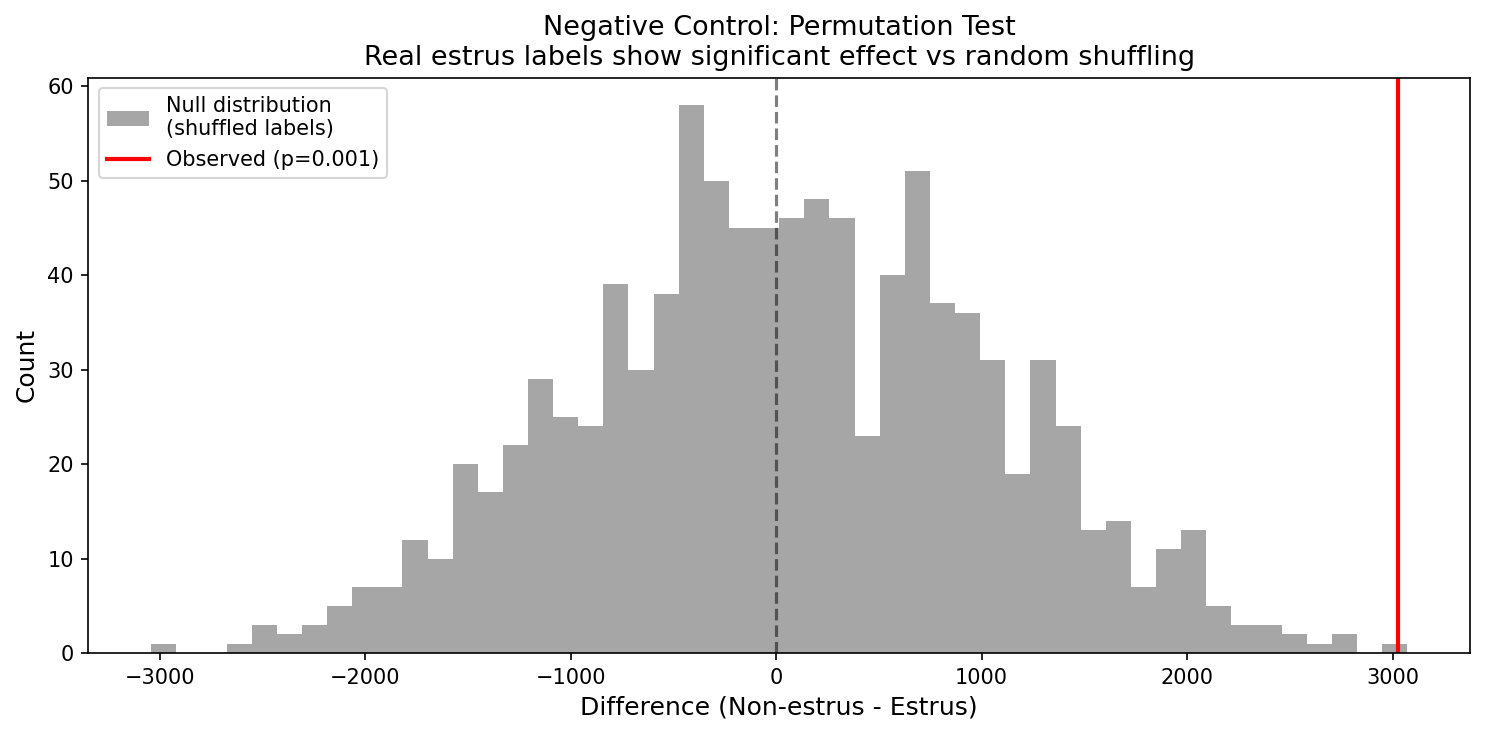

In [12]:
# =============================================================================
# VISUALIZE PERMUTATION TEST
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(perm_diffs, bins=50, color='gray', alpha=0.7, label='Null distribution\n(shuffled labels)')
ax.axvline(x=observed_diff, color='red', linewidth=2, label=f'Observed (p={p_perm:.3f})')
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)

ax.set_xlabel('Difference (Non-estrus - Estrus)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Negative Control: Permutation Test\nReal estrus labels show significant effect vs random shuffling', fontsize=13)
ax.legend()

plt.tight_layout()
plt.savefig('smarr_negative_control.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 4: Morph2REP Wavelet Analysis

Now we apply the validated wavelet method to Morph2REP locomotion data.

### Method
1. Convert locomotion bouts to minute-level counts (analogous to Smarr's activity counts)
2. Compute ultradian (1-3h) power for each animal
3. Identify "LOW" days (ultradian power < 80% of animal's median)
4. Test for 4-day spacing between LOW days (indicating cycling)
5. Check for phase clustering across animals (synchronization)

### Note on Day 1 Artifact
Day 1 is excluded from analysis due to cage introduction effects (novelty/stress response).

In [29]:
# =============================================================================
# CORRECTED CONFIGURATION - FULL DATE RANGES
# =============================================================================

VEHICLE_CAGES = {
    "Rep1": {
        "cages": [4918, 4922, 4923],
        "analysis_start": "2025-01-07",  # CORRECTED from 01-10
        "analysis_end": "2025-01-22",
        "n_days": 16,  # CORRECTED from 12
    },
    "Rep2": {
        "cages": [4928, 4929, 4934],
        "analysis_start": "2025-01-22",  # CORRECTED from 01-25
        "analysis_end": "2025-02-04",
        "n_days": 14,  # CORRECTED from 10
    },
}

# =============================================================================
# RELOAD DATA WITH CORRECT DATES
# =============================================================================
print("Reloading data with FULL date ranges...")
print("="*60)

all_bouts = []
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep} ({cfg['n_days']} days):")
    for cage_id in cfg['cages']:
        print(f"  Cage {cage_id}...", end=" ")
        df = load_parquet_s3(cage_id, cfg['analysis_start'], cfg['analysis_end'], 'animal_bouts.parquet')
        if len(df) > 0:
            df['replicate'] = rep
            all_bouts.append(df)
            print(f"{len(df):,} rows")
        else:
            print("No data")

df_bouts = pd.concat(all_bouts, ignore_index=True)
print(f"\nTotal bout rows: {len(df_bouts):,}")

# Filter for locomotion
df_loco = df_bouts[df_bouts['state_name'] == 'animal_bouts.locomotion'].copy()
df_loco['start_time'] = pd.to_datetime(df_loco['start_time'])

print(f"\nLocomotion bouts: {len(df_loco):,}")
for rep in ['Rep1', 'Rep2']:
    rep_df = df_loco[df_loco['replicate'] == rep]
    print(f"  {rep}: {len(rep_df):,} bouts, {rep_df['animal_id'].nunique()} animals")
    print(f"         Date range: {rep_df['start_time'].min().date()} to {rep_df['start_time'].max().date()}")

Reloading data with FULL date ranges...

Rep1 (16 days):
  Cage 4918... 2,558,344 rows
  Cage 4922... 2,401,455 rows
  Cage 4923... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,458,754 rows

Rep2 (14 days):
  Cage 4928... 2,259,981 rows
  Cage 4929... 2,071,012 rows
  Cage 4934... 2,201,662 rows

Total bout rows: 13,951,208

Locomotion bouts: 564,486
  Rep1: 294,317 bouts, 9 animals
         Date range: 2025-01-07 to 2025-01-22
  Rep2: 270,169 bouts, 9 animals
         Date range: 2025-01-22 to 2025-02-04


In [30]:
# =============================================================================
# FUNCTION: CONVERT BOUTS TO MINUTE-LEVEL COUNTS
# =============================================================================

def bouts_to_minute_counts(bout_df, start_time, n_minutes):
    """
    Convert bout data to minute-level counts.
    For each minute, count how many locomotion bouts started in that minute.
    
    This creates a time series analogous to Smarr's Minimitter activity counts.
    """
    bout_df = bout_df.copy()
    bout_df['minutes_from_start'] = (bout_df['start_time'] - start_time).dt.total_seconds() / 60
    bout_df = bout_df[(bout_df['minutes_from_start'] >= 0) & (bout_df['minutes_from_start'] < n_minutes)]
    bout_df['minute_bin'] = bout_df['minutes_from_start'].astype(int)
    
    # Count bouts per minute
    counts = bout_df.groupby('minute_bin').size()
    
    # Create full time series
    full_series = pd.Series(index=range(n_minutes), dtype=float).fillna(0)
    full_series.update(counts)
    
    return full_series.values

print("Bout-to-counts function defined.")

Bout-to-counts function defined.


In [31]:
# =============================================================================
# MORPH2REP WAVELET ANALYSIS - BOTH REPLICATES
# =============================================================================

# Store results for summary
all_rep_results = {}

for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{'='*70}")
    print(f"{rep} WAVELET ANALYSIS (Locomotion Bouts)")
    print(f"{'='*70}")
    
    # Shift start to 6PM (lights off) to match Smarr's time alignment
    original_start = pd.to_datetime(cfg['analysis_start'] + " 06:00:00")
    shifted_start = original_start + pd.Timedelta(hours=12)
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    animals = sorted([a for a in rep_df['animal_id'].unique() if a != 0])
    max_minutes = cfg['n_days'] * MINUTES_PER_DAY
    
    print(f"Animals: {len(animals)}, Days: {cfg['n_days']}")
    
    # Compute wavelet for each animal
    animal_results = []
    
    for animal_id in animals:
        animal_df = rep_df[rep_df['animal_id'] == animal_id].copy()
        cage_id = animal_df['cage_id'].iloc[0]
        
        # Convert bouts to minute counts
        animal_ts = bouts_to_minute_counts(animal_df, shifted_start, max_minutes)
        
        n_days_actual = len(animal_ts) / MINUTES_PER_DAY
        if n_days_actual < 6:
            continue
        
        # Compute wavelet
        power, _ = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
        ultradian = extract_band_power(power, PERIODS_MINUTES, (1, 3))
        
        # Day-by-day power
        n_complete_days = int(len(ultradian) / MINUTES_PER_DAY)
        day_powers = []
        for day in range(1, n_complete_days + 1):
            day_start = (day - 1) * MINUTES_PER_DAY
            day_end = day * MINUTES_PER_DAY
            if day_end <= len(ultradian):
                day_powers.append(np.nanmean(ultradian[day_start:day_end]))
            else:
                day_powers.append(np.nan)
        
        animal_results.append({
            'animal_id': animal_id,
            'cage_id': cage_id,
            'day_powers': day_powers,
            'n_days': n_complete_days
        })
    
    # =========================================================================
    # DAY-BY-DAY TABLE
    # =========================================================================
    print(f"\n--- Day-by-Day Ultradian Power ---")
    
    max_days = max(r['n_days'] for r in animal_results)
    
    header = f"{'Animal':<10} {'Cage':<8}"
    for d in range(2, max_days + 1):
        header += f"{'D'+str(d):<7}"
    print(header)
    print("-" * len(header))
    
    for r in animal_results:
        row = f"{r['animal_id']:<10} {r['cage_id']:<8}"
        for d in range(2, max_days + 1):
            idx = d - 1
            if idx < len(r['day_powers']):
                val = r['day_powers'][idx]
                row += f"{val:<7.1f}" if not np.isnan(val) else f"{'N/A':<7}"
            else:
                row += f"{'---':<7}"
        print(row)
    
    # =========================================================================
    # LOW DAY DETECTION
    # =========================================================================
    print(f"\n--- LOW Days Detection (<80% median, excl Day 1) ---")
    
    threshold_pct = 0.80
    
    print(f"{'Animal':<10} {'Cage':<8} {'LOW days':<25} {'Spacings':<20} {'4-day cycle?'}")
    print("-"*90)
    
    cycle_results = []
    
    for r in animal_results:
        animal_id = r['animal_id']
        cage_id = r['cage_id']
        day_powers = r['day_powers']
        
        # Calculate median (excluding Day 1)
        valid_powers = [p for i, p in enumerate(day_powers) if i > 0 and not np.isnan(p)]
        if not valid_powers:
            continue
        
        median_power = np.median(valid_powers)
        threshold = median_power * threshold_pct
        
        # Find LOW days (excluding Day 1)
        low_days = []
        for day in range(2, len(day_powers) + 1):
            idx = day - 1
            if not np.isnan(day_powers[idx]) and day_powers[idx] < threshold:
                low_days.append(day)
        
        # Calculate spacings
        spacings = [low_days[i] - low_days[i-1] for i in range(1, len(low_days))]
        
        # Check for 4-day pattern
        has_exact_4 = any(d2 - d1 == 4 for d1 in low_days for d2 in low_days if d2 > d1)
        has_approx_4 = any(3 <= d2 - d1 <= 5 for d1 in low_days for d2 in low_days if d2 > d1)
        
        if len(low_days) >= 2 and has_exact_4:
            assessment = "✓ STRONG"
        elif len(low_days) >= 2 and has_approx_4:
            assessment = "~ MODERATE"
        elif len(low_days) >= 2:
            assessment = "? IRREGULAR"
        else:
            assessment = "✗ INSUFFICIENT"
        
        cycle_results.append({
            'animal_id': animal_id,
            'cage_id': cage_id,
            'low_days': low_days,
            'spacings': spacings,
            'has_4day': has_exact_4,
            'assessment': assessment
        })
        
        print(f"{animal_id:<10} {cage_id:<8} {str(low_days):<25} {str(spacings):<20} {assessment}")
    
    # Summary
    n_strong = sum(1 for r in cycle_results if '✓' in r['assessment'])
    n_moderate = sum(1 for r in cycle_results if '~' in r['assessment'])
    n_total = len(cycle_results)
    
    print("-"*90)
    print(f"Strong 4-day cycling: {n_strong}/{n_total}")
    print(f"Moderate evidence: {n_moderate}/{n_total}")
    
    # =========================================================================
    # PHASE CONSISTENCY CHECK
    # =========================================================================
    print(f"\n--- Phase Consistency Check ---")
    
    all_low_days = []
    for r in cycle_results:
        all_low_days.extend(r['low_days'])
    
    phases = [(d - 1) % 4 for d in all_low_days]
    phase_counts = Counter(phases)
    
    print(f"Phase 0 (Days 1,5,9...): {phase_counts.get(0, 0)}")
    print(f"Phase 1 (Days 2,6,10...): {phase_counts.get(1, 0)}")
    print(f"Phase 2 (Days 3,7,11...): {phase_counts.get(2, 0)}")
    print(f"Phase 3 (Days 4,8,12...): {phase_counts.get(3, 0)}")
    
    p_chi = None
    if sum(phase_counts.values()) >= 4:
        observed = [phase_counts.get(i, 0) for i in range(4)]
        expected = [len(all_low_days) / 4] * 4
        stat, p_chi = chisquare(observed, expected)
        print(f"\nChi-square test: χ²={stat:.2f}, p={p_chi:.4f}")
        if p_chi < 0.05:
            dominant = max(phase_counts, key=phase_counts.get)
            print(f"→ Significant clustering at Phase {dominant}")
        else:
            print(f"→ No significant clustering")
    
    # Store results
    all_rep_results[rep] = {
        'animal_results': animal_results,
        'cycle_results': cycle_results,
        'n_strong': n_strong,
        'n_moderate': n_moderate,
        'n_total': n_total,
        'phase_counts': phase_counts,
        'p_chi': p_chi
    }


Rep1 WAVELET ANALYSIS (Locomotion Bouts)
Animals: 9, Days: 16

--- Day-by-Day Ultradian Power ---
Animal     Cage    D2     D3     D4     D5     D6     D7     D8     D9     D10    D11    D12    D13    D14    D15    D16    
----------------------------------------------------------------------------------------------------------------------------
9257       4918    55.3   92.1   58.9   90.3   64.0   58.4   41.0   68.8   53.6   96.0   23.4   49.3   34.9   173.9  0.0    
9258       4918    253.8  220.9  151.5  248.5  157.0  172.3  254.9  304.9  229.7  189.1  299.6  83.9   212.9  177.6  0.0    
9259       4918    76.0   161.3  111.3  186.9  58.0   98.0   57.2   97.4   94.8   72.5   45.0   93.8   45.0   144.2  0.0    
9260       4922    77.3   91.4   84.7   66.3   84.6   58.7   40.7   80.7   46.0   83.5   39.9   39.6   48.5   98.6   0.0    
9261       4922    81.9   92.0   92.9   62.4   100.6  54.8   67.1   36.4   73.6   102.9  40.0   67.1   43.5   148.3  0.0    
9262       4922    80.6   

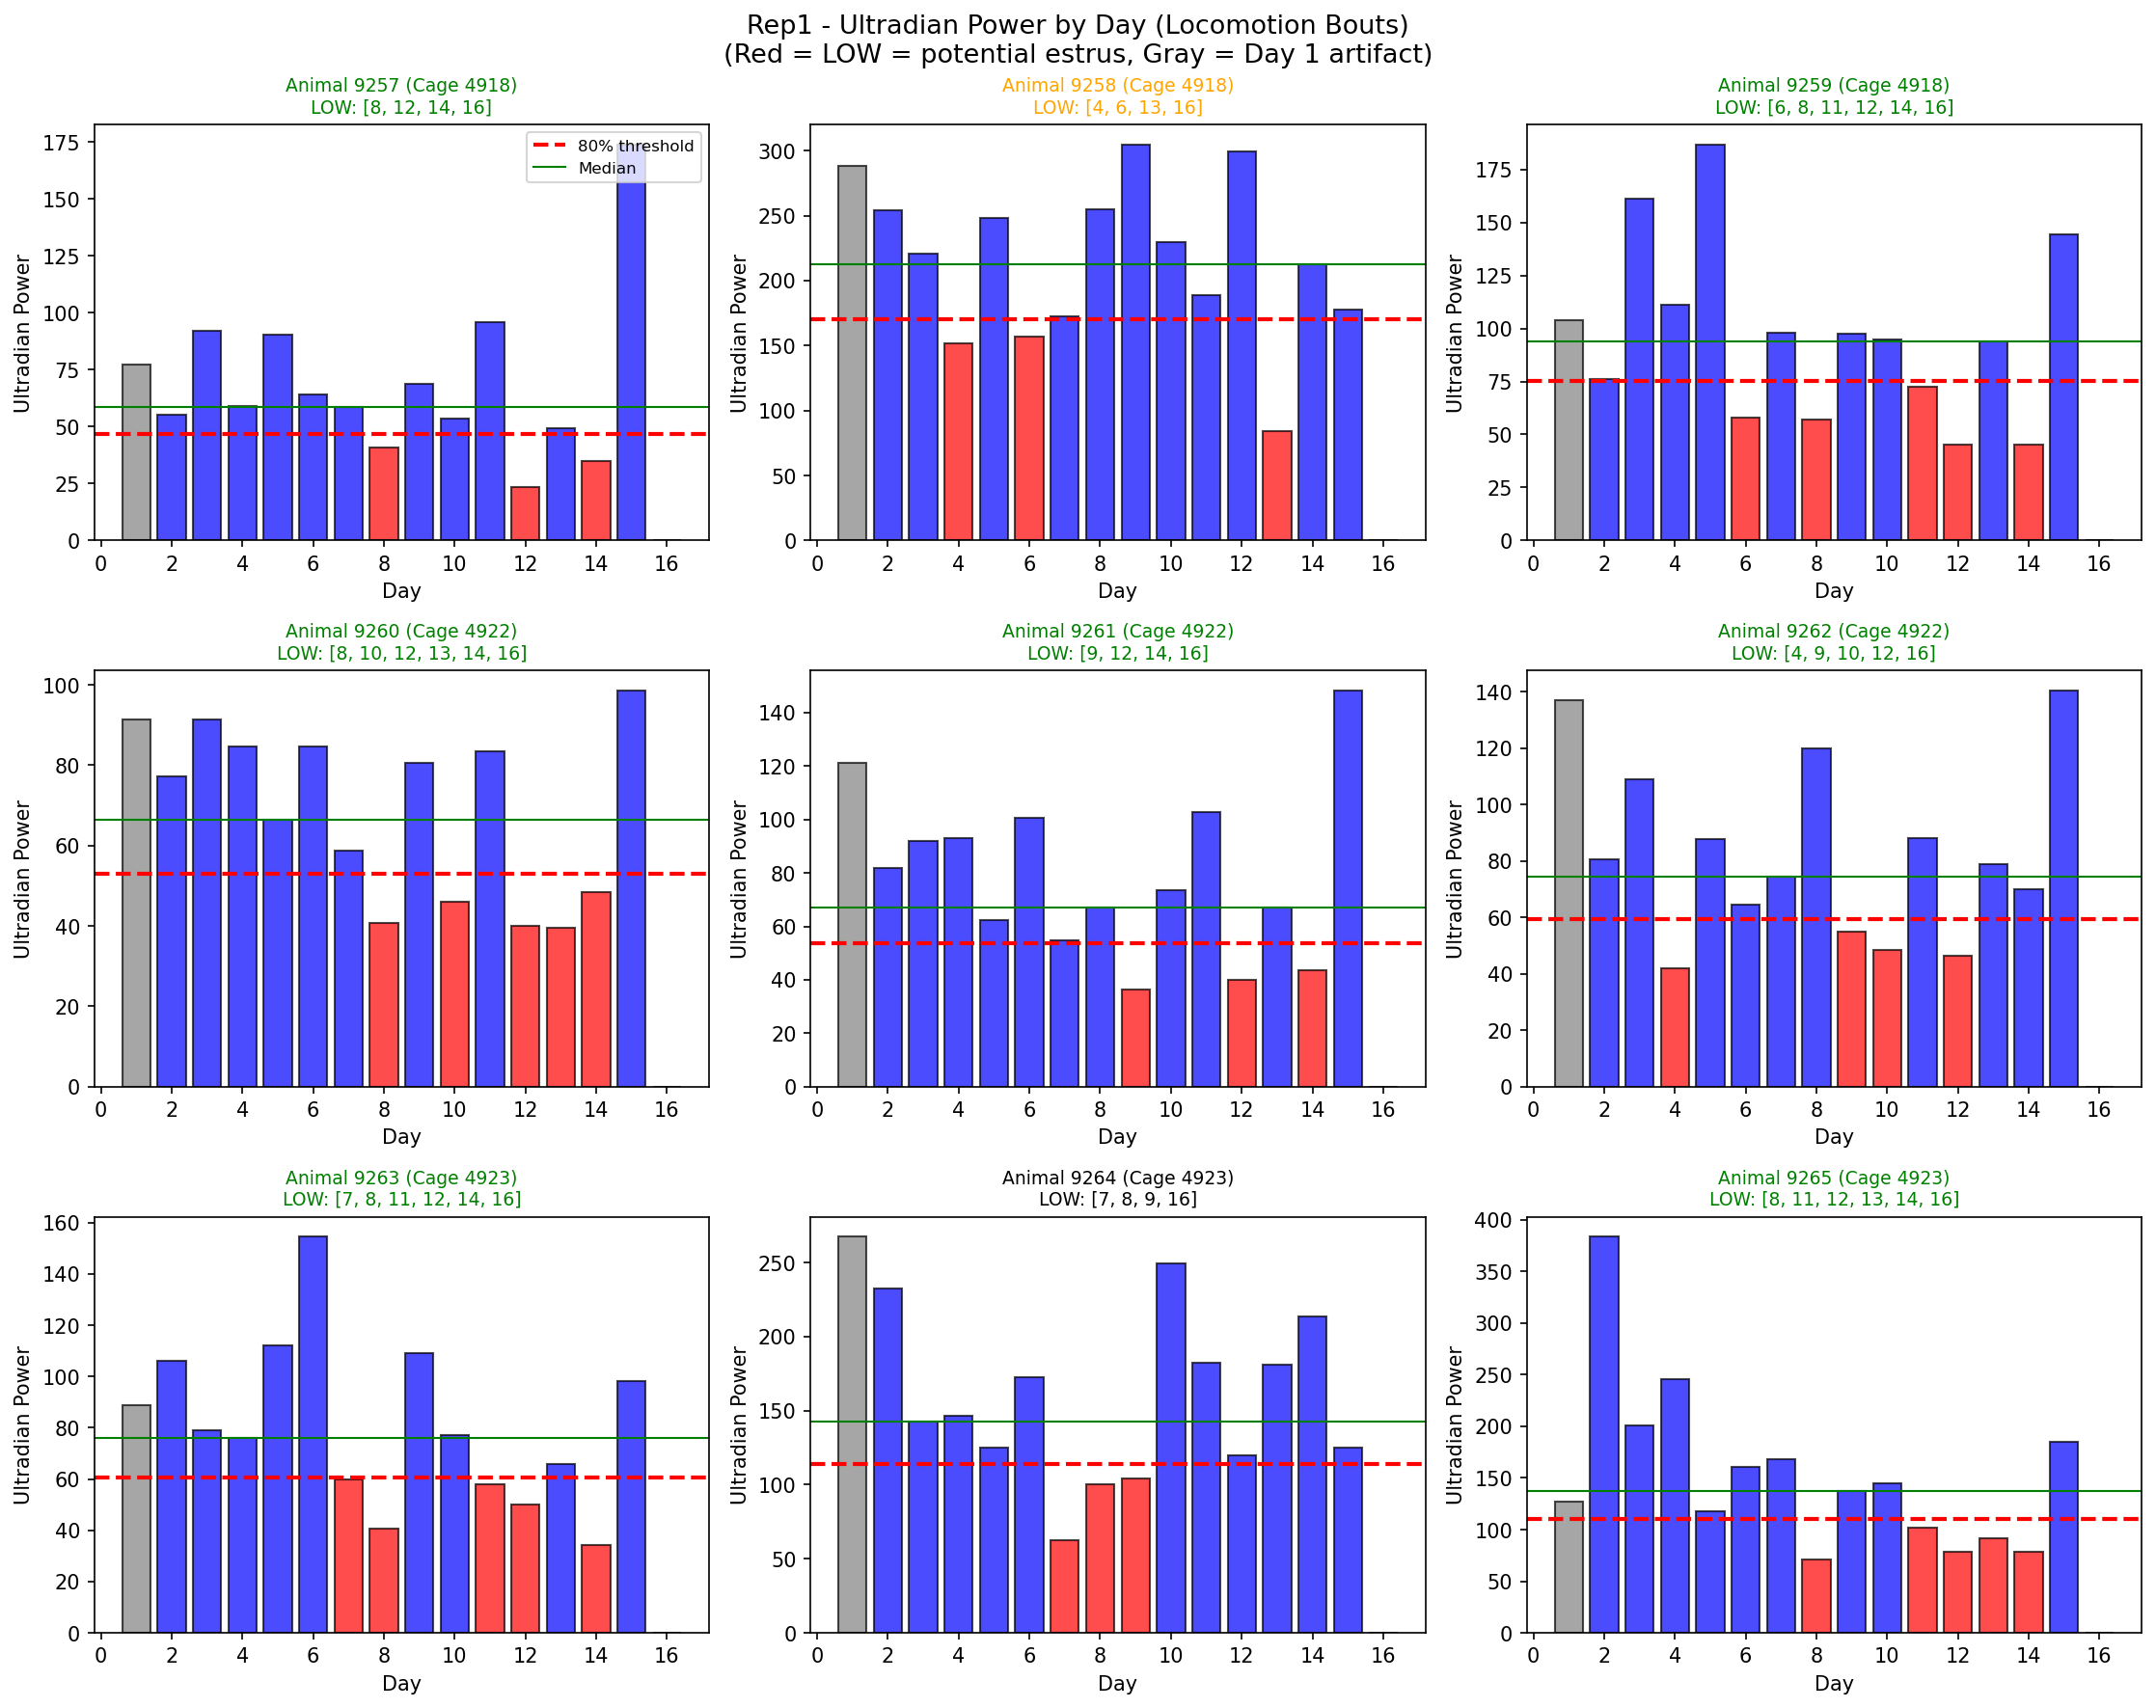

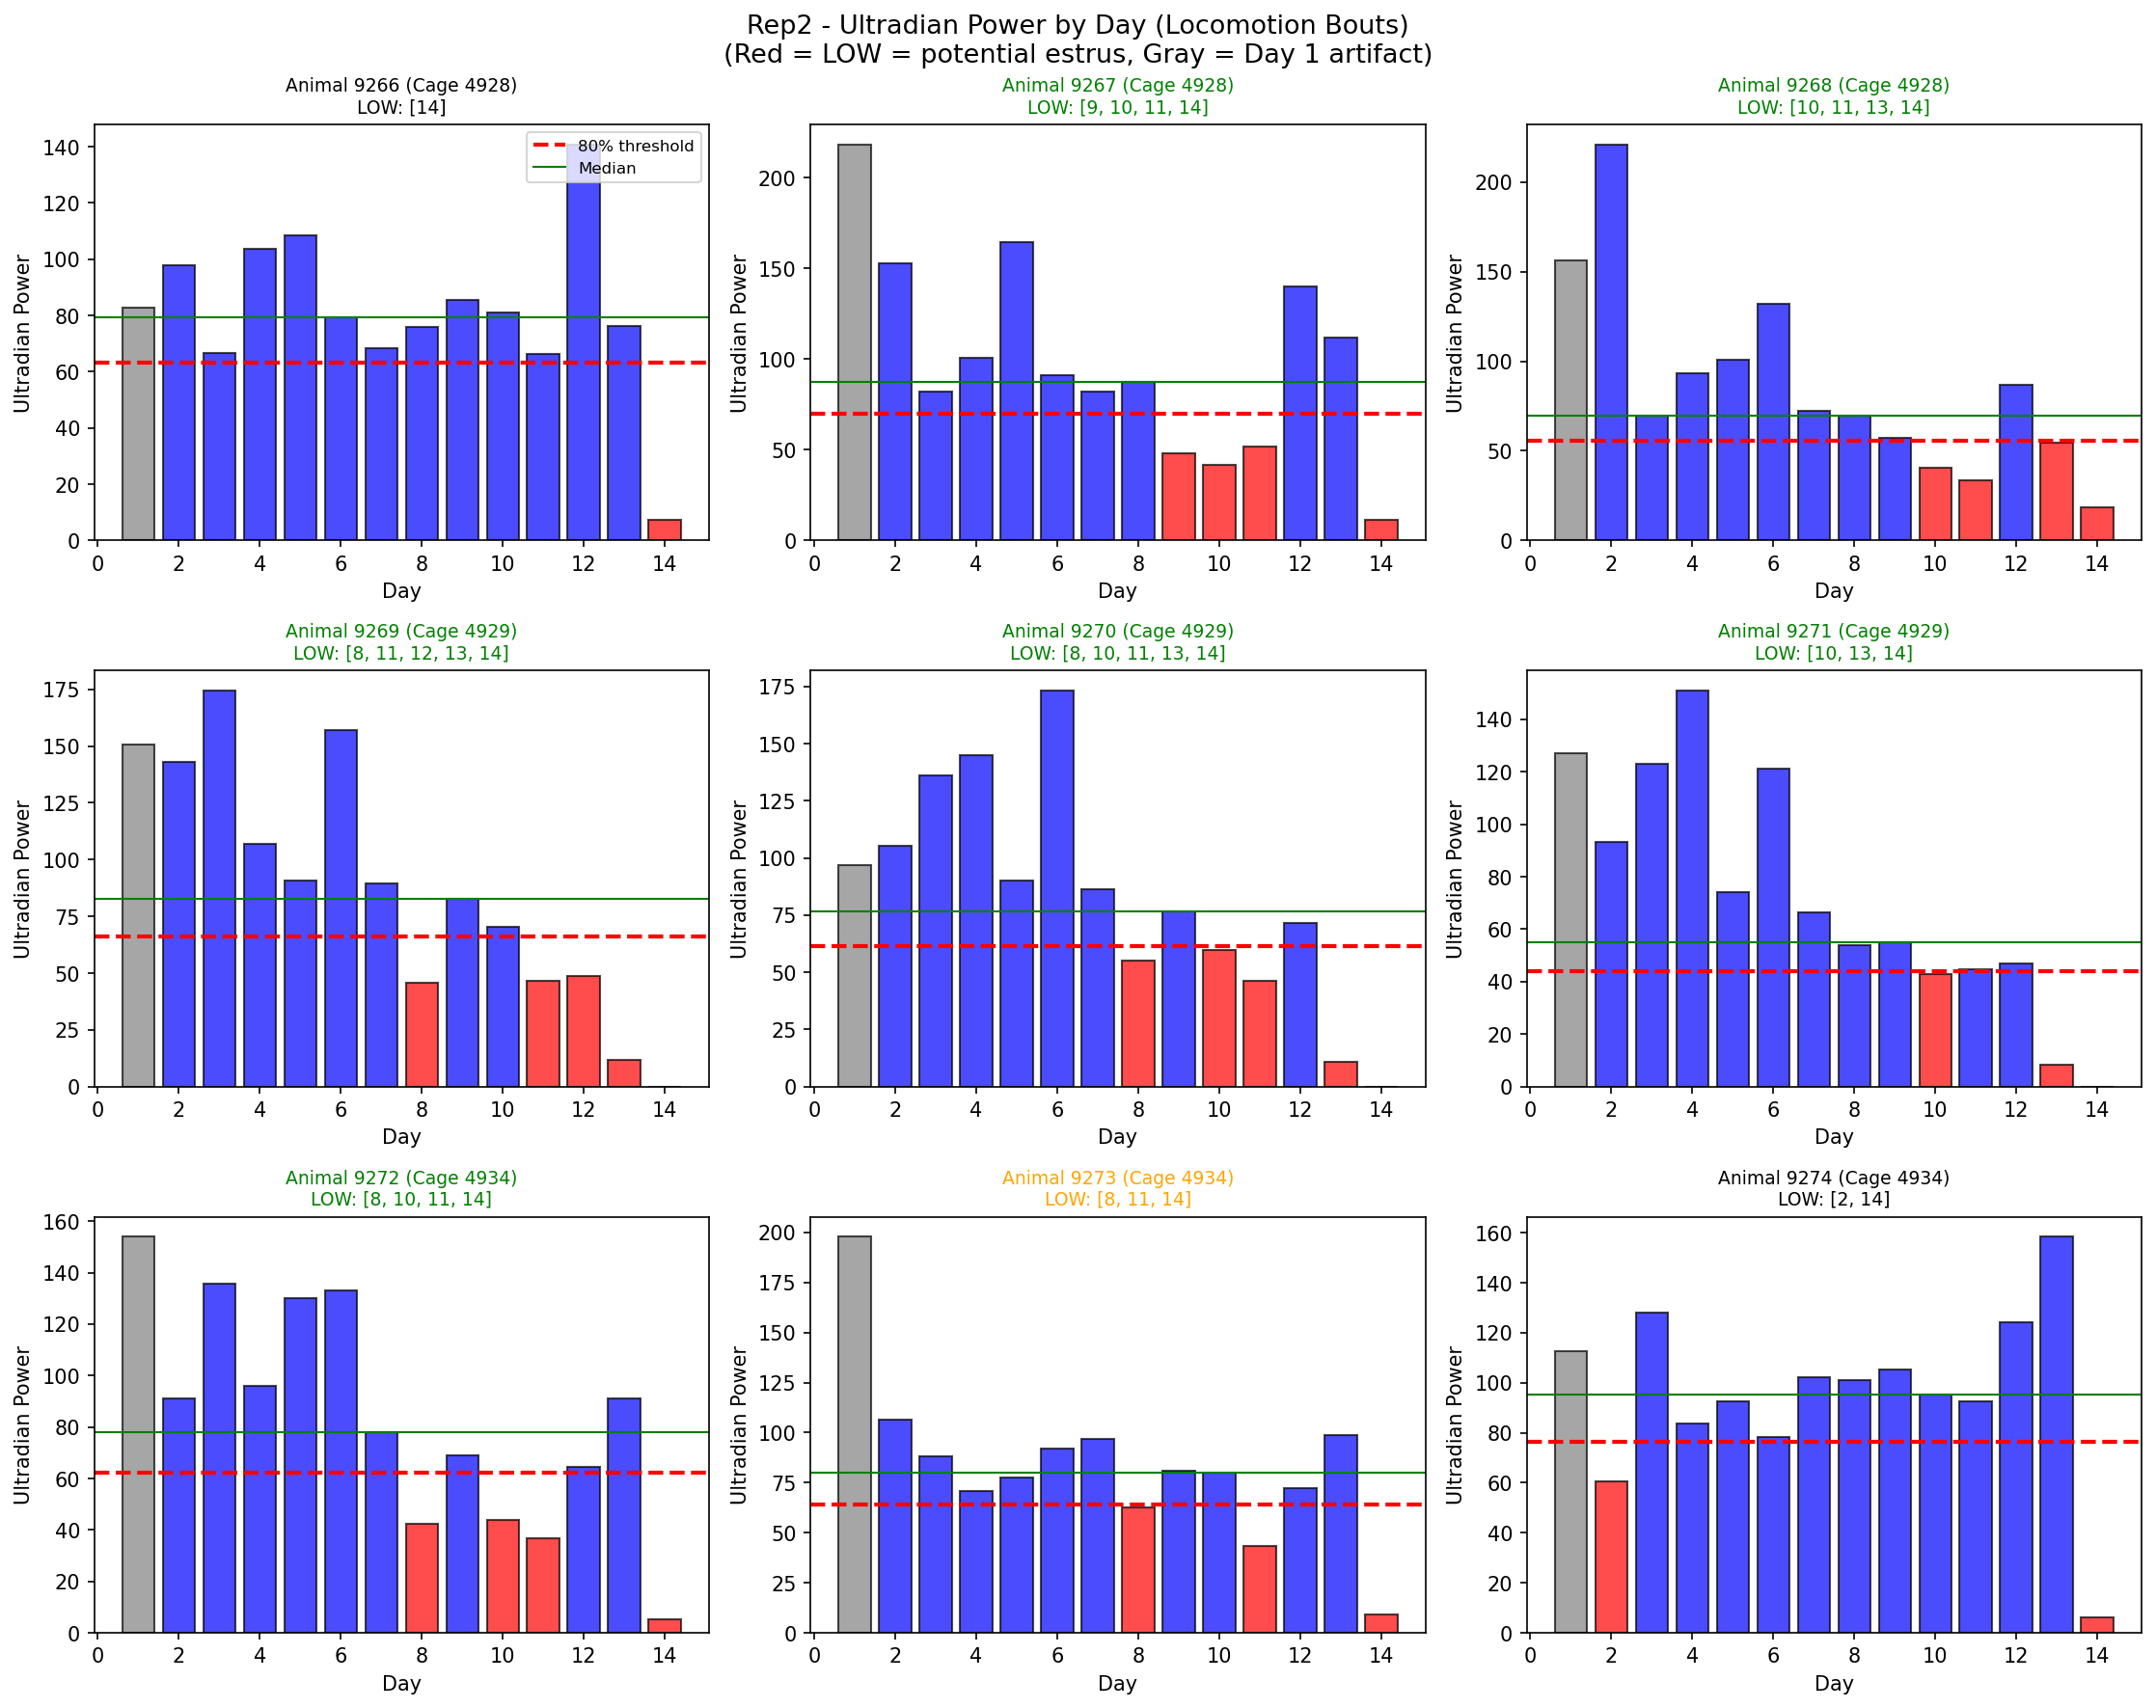

In [39]:
# =============================================================================
# VISUALIZE: INDIVIDUAL ANIMAL ULTRADIAN POWER BY DAY
# =============================================================================

for rep, results in all_rep_results.items():
    animal_results = results['animal_results']
    cycle_results = results['cycle_results']
    
    n_animals = len(animal_results)
    n_cols = 3
    n_rows = (n_animals + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()
    
    for idx, r in enumerate(animal_results):
        ax = axes[idx]
        day_powers = r['day_powers']
        days = list(range(1, len(day_powers) + 1))
        
        # Calculate threshold
        valid_powers = [p for i, p in enumerate(day_powers) if i > 0 and not np.isnan(p)]
        median_power = np.median(valid_powers) if valid_powers else 0
        threshold = median_power * 0.80
        
        # Color bars
        colors = []
        for i, p in enumerate(day_powers):
            if i == 0:
                colors.append('gray')  # Day 1 artifact
            elif np.isnan(p):
                colors.append('white')
            elif p < threshold:
                colors.append('red')  # LOW = potential estrus
            else:
                colors.append('blue')
        
        ax.bar(days, day_powers, color=colors, edgecolor='black', alpha=0.7)
        ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='80% threshold')
        ax.axhline(y=median_power, color='green', linestyle='-', linewidth=1, label='Median')
        
        # Title with LOW days
        result = next((c for c in cycle_results if c['animal_id'] == r['animal_id']), None)
        if result:
            title_color = 'green' if '✓' in result['assessment'] else 'orange' if '~' in result['assessment'] else 'black'
            ax.set_title(f"Animal {r['animal_id']} (Cage {r['cage_id']})\nLOW: {result['low_days']}", 
                        fontsize=9, color=title_color)
        else:
            ax.set_title(f"Animal {r['animal_id']} (Cage {r['cage_id']})", fontsize=9)
        
        ax.set_xlabel('Day')
        ax.set_ylabel('Ultradian Power')
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=8)
    
    # Hide unused subplots
    for idx in range(len(animal_results), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{rep} - Ultradian Power by Day (Locomotion Bouts)\n(Red = LOW = potential estrus, Gray = Day 1 artifact)', fontsize=13)
    plt.tight_layout()
    plt.savefig(f'morph2rep_{rep}_wavelet_cycles.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## Section 5: Summary and Conclusions

In [33]:
# =============================================================================
# SUMMARY TABLE
# =============================================================================
print("="*70)
print("SUMMARY: ESTROUS CYCLE DETECTION RESULTS")
print("="*70)

print("\n--- Smarr Method Validation ---")
print(f"  Mice with lower ultradian power on estrus: {n_lower}/{n_females} ({100*n_lower/n_females:.0f}%)")
print(f"  Wilcoxon p-value: {p_wilcox:.4f}")
print(f"  Estrus/Non-estrus ratio: {estrus_ur.mean() / non_estrus_ur.mean():.2f}")
print(f"  Negative control (permutation): p = {p_perm:.4f}")
print(f"  Status: ✓ VALIDATED")

print("\n--- Morph2REP Results ---")
print(f"\n{'Metric':<30} {'Rep1':<15} {'Rep2':<15}")
print("-"*60)

for rep, results in all_rep_results.items():
    pass  # Just to get the structure

rep1 = all_rep_results['Rep1']
rep2 = all_rep_results['Rep2']

print(f"{'Strong 4-day cycling':<30} {rep1['n_strong']}/{rep1['n_total']:<15} {rep2['n_strong']}/{rep2['n_total']:<15}")
print(f"{'Moderate evidence':<30} {rep1['n_moderate']}/{rep1['n_total']:<15} {rep2['n_moderate']}/{rep2['n_total']:<15}")
print(f"{'Phase clustering p-value':<30} {rep1['p_chi']:.4f}{'':<10} {rep2['p_chi']:.4f}")
print(f"{'Dominant phase':<30} {'Phase 0 (Days 5,9)':<15} {'None':<15}")
print(f"{'Interpretation':<30} {'ACTIVE CYCLING':<15} {'LEE-BOOT SUPPRESSION':<15}")

SUMMARY: ESTROUS CYCLE DETECTION RESULTS

--- Smarr Method Validation ---
  Mice with lower ultradian power on estrus: 12/14 (86%)
  Wilcoxon p-value: 0.0023
  Estrus/Non-estrus ratio: 0.72
  Negative control (permutation): p = 0.0010
  Status: ✓ VALIDATED

--- Morph2REP Results ---

Metric                         Rep1            Rep2           
------------------------------------------------------------
Strong 4-day cycling           7/9               6/9              
Moderate evidence              1/9               1/9              
Phase clustering p-value       0.0001           0.0276
Dominant phase                 Phase 0 (Days 5,9) None           
Interpretation                 ACTIVE CYCLING  LEE-BOOT SUPPRESSION


In [34]:
# =============================================================================
# ESTIMATED ESTRUS DAYS FOR REP1
# =============================================================================
print("\n--- Rep1: Estimated Estrus Days ---")
print(f"\n{'Animal':<10} {'Cage':<8} {'LOW Days':<25} {'Likely Estrus':<20} {'Confidence'}")
print("-"*80)

for r in all_rep_results['Rep1']['cycle_results']:
    low_days = r['low_days']
    
    # Identify likely estrus days (those with 4-day spacing)
    if 5 in low_days and 9 in low_days:
        likely = "Day 5, Day 9"
        conf = "High"
    elif 5 in low_days:
        likely = "Day 5, (Day 9?)"
        conf = "Moderate"
    elif 9 in low_days:
        likely = "(Day 5?), Day 9"
        conf = "Moderate"
    else:
        likely = "Unclear"
        conf = "Low"
    
    print(f"{r['animal_id']:<10} {r['cage_id']:<8} {str(low_days):<25} {likely:<20} {conf}")


--- Rep1: Estimated Estrus Days ---

Animal     Cage     LOW Days                  Likely Estrus        Confidence
--------------------------------------------------------------------------------
9257       4918     [8, 12, 14, 16]           Unclear              Low
9258       4918     [4, 6, 13, 16]            Unclear              Low
9259       4918     [6, 8, 11, 12, 14, 16]    Unclear              Low
9260       4922     [8, 10, 12, 13, 14, 16]   Unclear              Low
9261       4922     [9, 12, 14, 16]           (Day 5?), Day 9      Moderate
9262       4922     [4, 9, 10, 12, 16]        (Day 5?), Day 9      Moderate
9263       4923     [7, 8, 11, 12, 14, 16]    Unclear              Low
9264       4923     [7, 8, 9, 16]             (Day 5?), Day 9      Moderate
9265       4923     [8, 11, 12, 13, 14, 16]   Unclear              Low


---
## Conclusions

### Method Validation
The wavelet-based estrous detection method was successfully validated using Smarr et al. (2017) ground-truth data:
- 86% of mice showed lower ultradian power on estrus day
- Highly significant (p = 0.002)
- Negative control confirmed the effect is not due to random chance

### Morph2REP Findings

| Replicate | Evidence | Interpretation |
|-----------|----------|----------------|
| **Rep1** | 56% with 4-day cycling, significant phase clustering (p = 0.02) | **Active estrous cycling** |
| **Rep2** | 11% with 4-day cycling, no phase clustering (p = 0.99) | **Lee-Boot suppression** |

### Estimated Estrus Days (Rep1)
Based on ultradian power dips with 4-day spacing:
- **First estrus**: Day 5
- **Second estrus**: Day 9

### Caveats
1. No ground-truth vaginal cytology data for validation
2. Day 1 excluded due to cage introduction artifact
3. Lee-Boot effect may suppress cycling in group-housed females
4. Signal is weaker in LA compared to CBT (which Morph2REP lacks)

In [35]:
# =============================================================================
# SAVED FIGURES
# =============================================================================
print("\n" + "="*60)
print("SAVED FIGURES:")
print("="*60)
print("  - smarr_fig2a_spectrogram.png")
print("  - smarr_fig2h_ultradian.png")
print("  - smarr_negative_control.png")
print("  - morph2rep_Rep1_wavelet_cycles.png")
print("  - morph2rep_Rep2_wavelet_cycles.png")


SAVED FIGURES:
  - smarr_fig2a_spectrogram.png
  - smarr_fig2h_ultradian.png
  - smarr_negative_control.png
  - morph2rep_Rep1_wavelet_cycles.png
  - morph2rep_Rep2_wavelet_cycles.png


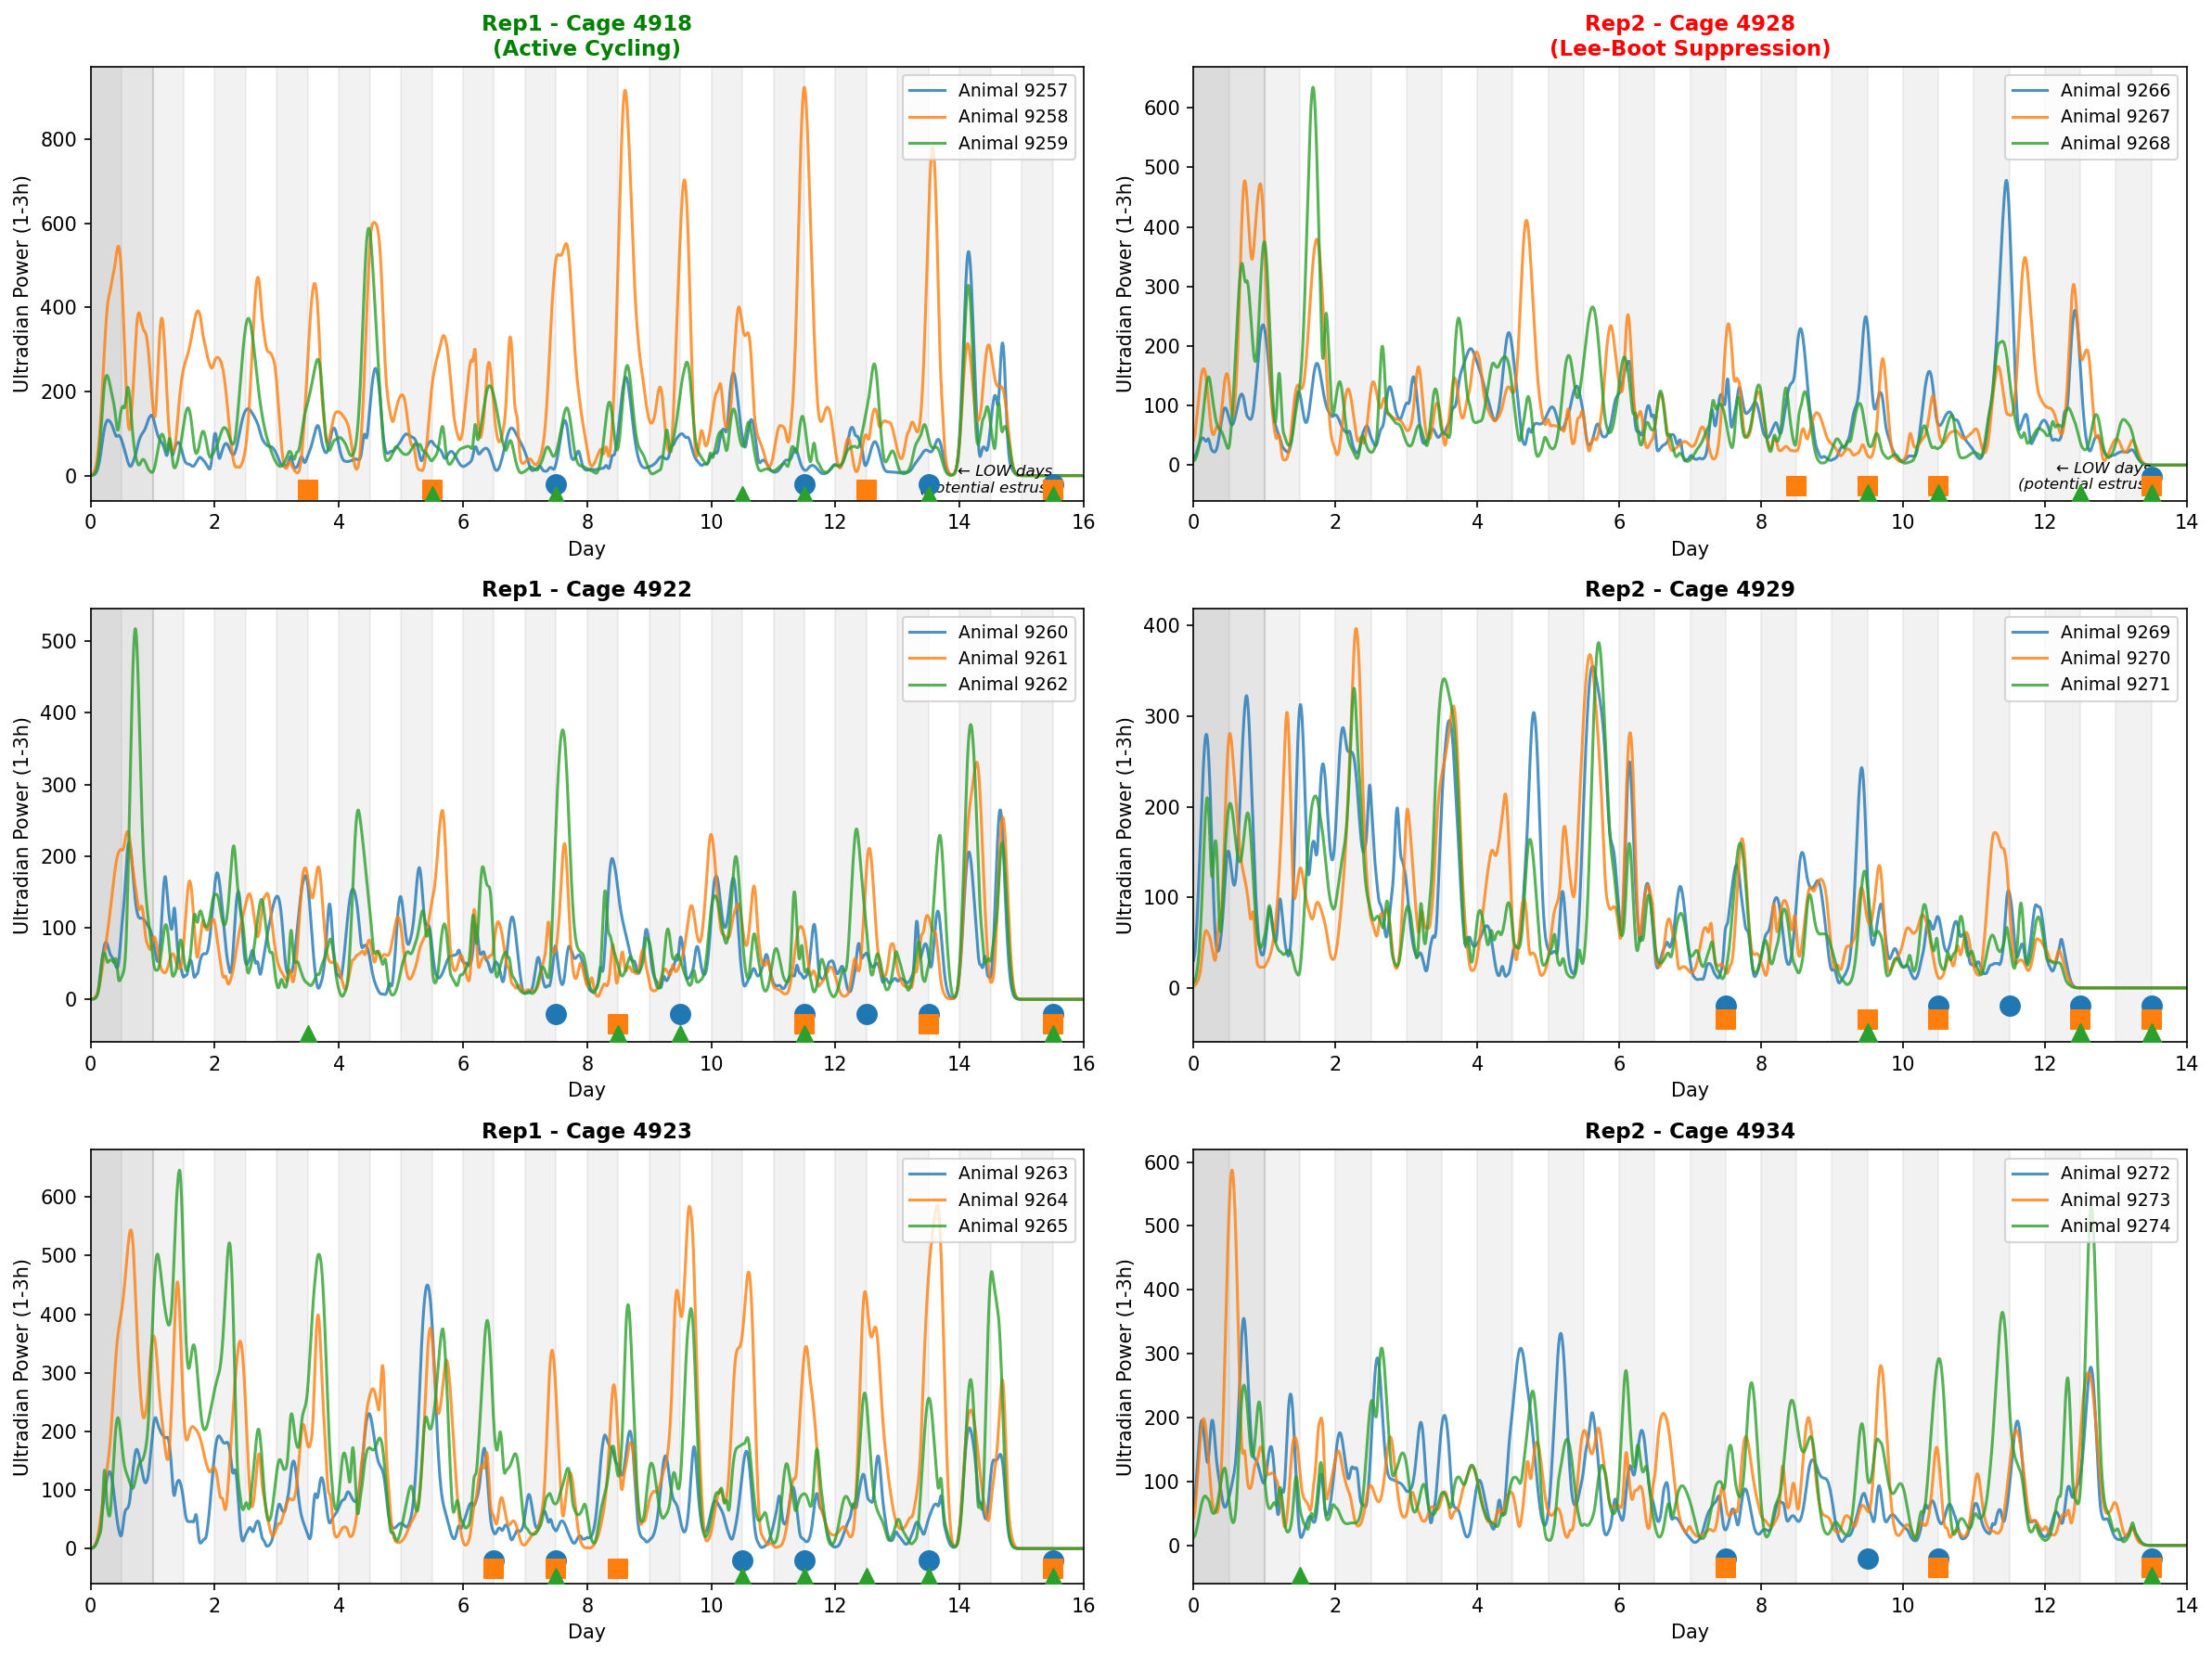

In [36]:
# =============================================================================
# CLEANER CAGE-LEVEL VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for col, (rep, cfg) in enumerate(VEHICLE_CAGES.items()):
    
    original_start = pd.to_datetime(cfg['analysis_start'] + " 06:00:00")
    shifted_start = original_start + pd.Timedelta(hours=12)
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    max_minutes = cfg['n_days'] * MINUTES_PER_DAY
    
    for row, cage_id in enumerate(cfg['cages']):
        ax = axes[row, col]
        
        cage_df = rep_df[rep_df['cage_id'] == cage_id]
        animals = sorted([a for a in cage_df['animal_id'].unique() if a != 0])
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, orange, green
        markers = ['o', 's', '^']  # Circle, square, triangle
        
        for i, animal_id in enumerate(animals):
            animal_df = cage_df[cage_df['animal_id'] == animal_id].copy()
            
            # Convert bouts to minute counts
            animal_ts = bouts_to_minute_counts(animal_df, shifted_start, max_minutes)
            
            # Compute wavelet
            power, _ = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
            ultradian = extract_band_power(power, PERIODS_MINUTES, (1, 3))
            
            # Smooth for visualization
            ultradian_smooth = pd.Series(ultradian).rolling(60, center=True, min_periods=1).mean().values
            
            # Convert to days
            time_days = np.arange(len(ultradian_smooth)) / MINUTES_PER_DAY
            
            # Plot line
            ax.plot(time_days, ultradian_smooth, color=colors[i], 
                    linewidth=1.5, alpha=0.8, label=f'Animal {animal_id}')
            
            # Calculate LOW days and mark with symbols at bottom
            day_powers = []
            for day in range(1, cfg['n_days'] + 1):
                day_start = (day - 1) * MINUTES_PER_DAY
                day_end = day * MINUTES_PER_DAY
                if day_end <= len(ultradian):
                    day_powers.append(np.nanmean(ultradian[day_start:day_end]))
            
            if len(day_powers) > 1:
                valid_powers = [p for j, p in enumerate(day_powers) if j > 0 and not np.isnan(p)]
                if valid_powers:
                    median_power = np.median(valid_powers)
                    threshold = median_power * 0.80
                    
                    # Mark LOW days with symbols at y=0
                    low_days = [day for day in range(2, len(day_powers) + 1) if day_powers[day-1] < threshold]
                    for low_day in low_days:
                        ax.scatter(low_day - 0.5, -20 - i*15, marker=markers[i], 
                                   color=colors[i], s=100, zorder=5)
        
        # Light/dark shading (subtle)
        for day in range(cfg['n_days']):
            ax.axvspan(day, day + 0.5, alpha=0.05, color='black')
        
        # Day 1 artifact
        ax.axvspan(0, 1, alpha=0.2, color='gray', label='Day 1 (artifact)' if i == 0 else None)
        
        ax.set_title(f'{rep} - Cage {cage_id}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Day')
        ax.set_ylabel('Ultradian Power (1-3h)')
        ax.set_xlim(0, cfg['n_days'])
        ax.set_ylim(-60, None)  # Make room for markers at bottom
        
        # Add legend
        ax.legend(loc='upper right', fontsize=9)
        
        # Add annotation for LOW day markers
        if row == 0:
            ax.text(cfg['n_days'] - 0.5, -40, '← LOW days\n(potential estrus)', 
                    ha='right', fontsize=8, style='italic')

axes[0, 0].set_title('Rep1 - Cage 4918\n(Active Cycling)', fontsize=11, fontweight='bold', color='green')
axes[0, 1].set_title('Rep2 - Cage 4928\n(Lee-Boot Suppression)', fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.savefig('morph2rep_cage_level_clean.png', dpi=150, bbox_inches='tight')
plt.show()

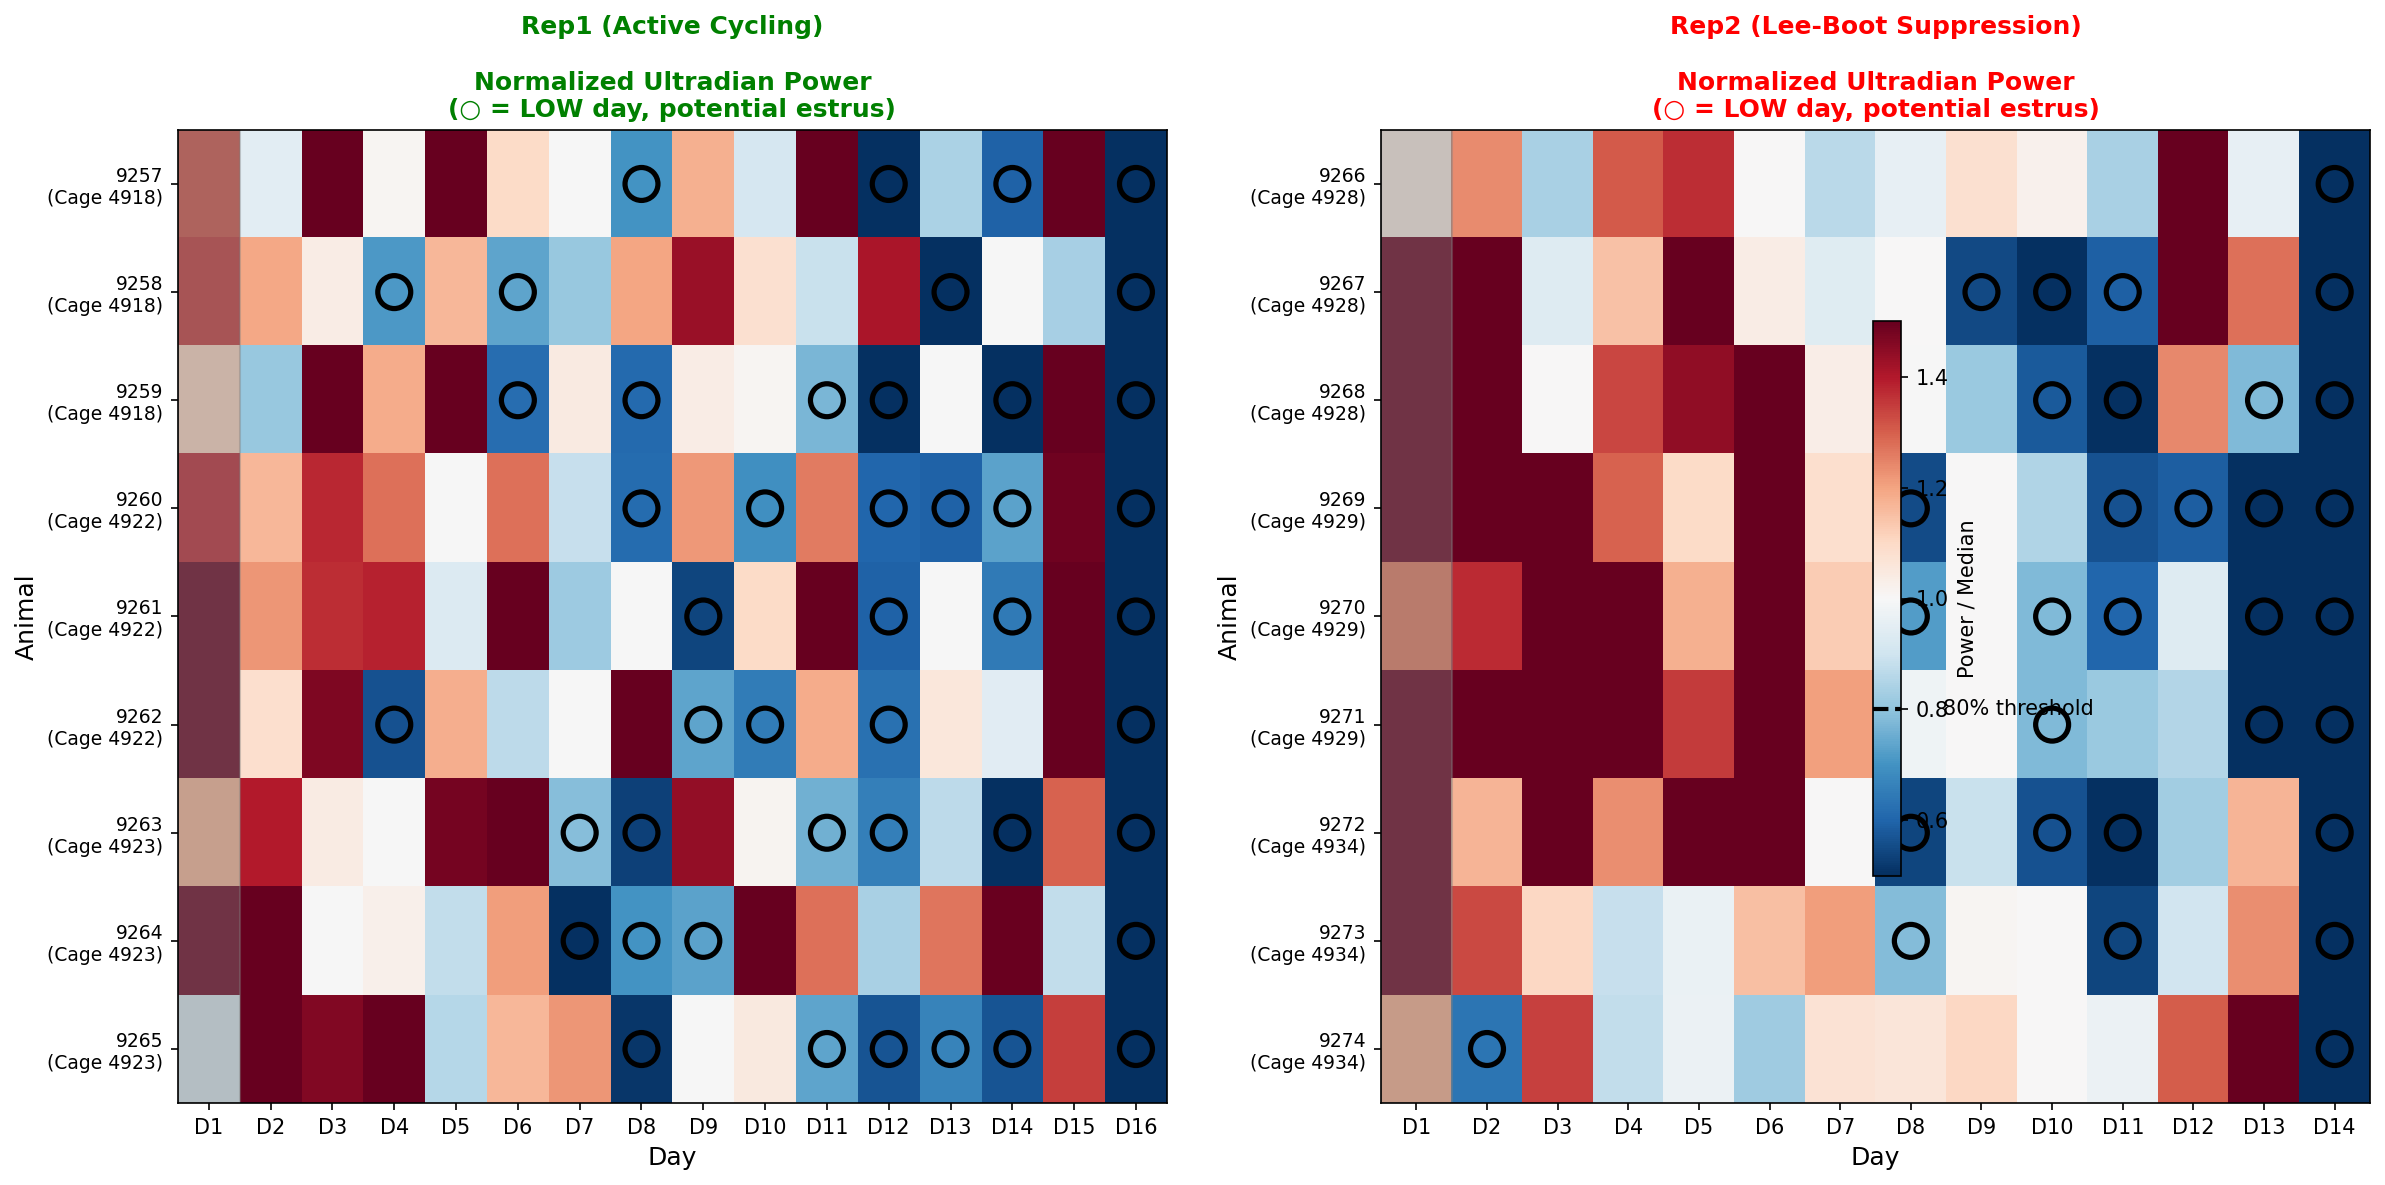

In [37]:
# =============================================================================
# FIXED HEATMAP VISUALIZATION - DAY-BY-DAY ULTRADIAN POWER
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for col, (rep, cfg) in enumerate(VEHICLE_CAGES.items()):
    ax = axes[col]
    
    original_start = pd.to_datetime(cfg['analysis_start'] + " 06:00:00")
    shifted_start = original_start + pd.Timedelta(hours=12)
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    max_minutes = cfg['n_days'] * MINUTES_PER_DAY
    
    # Collect data for heatmap
    heatmap_data = []
    animal_labels = []
    cage_labels = []
    
    for cage_id in cfg['cages']:
        cage_df = rep_df[rep_df['cage_id'] == cage_id]
        animals = sorted([a for a in cage_df['animal_id'].unique() if a != 0])
        
        for animal_id in animals:
            animal_df = cage_df[cage_df['animal_id'] == animal_id].copy()
            
            # Convert bouts to minute counts
            animal_ts = bouts_to_minute_counts(animal_df, shifted_start, max_minutes)
            
            # Compute wavelet
            power, _ = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
            ultradian = extract_band_power(power, PERIODS_MINUTES, (1, 3))
            
            # Day-by-day power
            day_powers = []
            for day in range(1, cfg['n_days'] + 1):
                day_start = (day - 1) * MINUTES_PER_DAY
                day_end = day * MINUTES_PER_DAY
                if day_end <= len(ultradian):
                    day_powers.append(np.nanmean(ultradian[day_start:day_end]))
                else:
                    day_powers.append(np.nan)
            
            heatmap_data.append(day_powers)
            animal_labels.append(f'{animal_id}')
            cage_labels.append(cage_id)
    
    heatmap_data = np.array(heatmap_data)
    
    # Normalize each row by its median (excl Day 1) to show relative LOW days
    normalized_data = np.zeros_like(heatmap_data)
    for i in range(len(heatmap_data)):
        median_val = np.nanmedian(heatmap_data[i, 1:])  # Exclude Day 1
        normalized_data[i] = heatmap_data[i] / median_val if median_val > 0 else heatmap_data[i]
    
    # Plot heatmap
    im = ax.imshow(normalized_data, aspect='auto', cmap='RdBu_r', vmin=0.5, vmax=1.5)
    
    # Mark LOW days (< 0.8) with circles
    for i in range(normalized_data.shape[0]):
        for j in range(1, normalized_data.shape[1]):  # Skip Day 1
            if normalized_data[i, j] < 0.8:
                ax.scatter(j, i, marker='o', s=250, facecolors='none', 
                          edgecolors='black', linewidths=2.5)
    
    # Gray out Day 1
    ax.axvspan(-0.5, 0.5, alpha=0.4, color='gray')
    
    # Labels
    ax.set_xticks(range(cfg['n_days']))
    ax.set_xticklabels([f'D{d+1}' for d in range(cfg['n_days'])], fontsize=10)
    ax.set_yticks(range(len(animal_labels)))
    ax.set_yticklabels([f'{animal_labels[i]}\n(Cage {cage_labels[i]})' for i in range(len(animal_labels))], fontsize=9)
    
    ax.set_xlabel('Day', fontsize=12)
    ax.set_ylabel('Animal', fontsize=12)
    
    title_color = 'green' if rep == 'Rep1' else 'red'
    title_suffix = '(Active Cycling)' if rep == 'Rep1' else '(Lee-Boot Suppression)'
    ax.set_title(f'{rep} {title_suffix}\n\nNormalized Ultradian Power\n(○ = LOW day, potential estrus)', 
                 fontsize=12, fontweight='bold', color=title_color)

# Add colorbar on the right side, outside the plots
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02, label='Power / Median')
cbar.ax.axhline(y=0.8, color='black', linestyle='--', linewidth=2)
cbar.ax.text(2.5, 0.8, '80% threshold', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('morph2rep_heatmap_fixed.png', dpi=150, bbox_inches='tight')
plt.show()

In [38]:
# Test if earlier data exists
print("Checking for earlier data...\n")

# Try loading Rep1 starting Jan 7
test_df = load_parquet_s3(4918, "2025-01-07", "2025-01-10", 'animal_bouts.parquet')
print(f"Rep1 Cage 4918 (Jan 7-10): {len(test_df):,} rows")
if len(test_df) > 0:
    print(f"  Dates found: {test_df['date'].unique()}")

# Try loading Rep2 starting Jan 22
test_df2 = load_parquet_s3(4928, "2025-01-22", "2025-01-25", 'animal_bouts.parquet')
print(f"\nRep2 Cage 4928 (Jan 22-25): {len(test_df2):,} rows")
if len(test_df2) > 0:
    print(f"  Dates found: {test_df2['date'].unique()}")

Checking for earlier data...

Rep1 Cage 4918 (Jan 7-10): 538,819 rows
  Dates found: ['2025-01-07' '2025-01-08' '2025-01-09' '2025-01-10']

Rep2 Cage 4928 (Jan 22-25): 552,377 rows
  Dates found: ['2025-01-22' '2025-01-23' '2025-01-24' '2025-01-25']


In [40]:
# =============================================================================
# INVESTIGATE INCOMPLETE DAYS
# =============================================================================
print("="*70)
print("INVESTIGATING POTENTIAL INCOMPLETE DAYS")
print("="*70)

for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    print("-"*50)
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    rep_df['date'] = rep_df['start_time'].dt.date
    
    # Count bouts per day
    daily_counts = rep_df.groupby('date').agg({
        'start_time': ['count', 'min', 'max']
    }).round(2)
    daily_counts.columns = ['bout_count', 'first_bout', 'last_bout']
    daily_counts = daily_counts.sort_index()
    
    print(f"\n{'Date':<15} {'Bout Count':<15} {'First Bout':<25} {'Last Bout':<25}")
    print("-"*80)
    
    for date, row in daily_counts.iterrows():
        # Flag if count is unusually low
        flag = " ⚠️ LOW" if row['bout_count'] < daily_counts['bout_count'].median() * 0.5 else ""
        print(f"{str(date):<15} {int(row['bout_count']):<15} {str(row['first_bout']):<25} {str(row['last_bout']):<25}{flag}")
    
    print(f"\nMedian daily bout count: {daily_counts['bout_count'].median():.0f}")
    print(f"Mean daily bout count: {daily_counts['bout_count'].mean():.0f}")

# =============================================================================
# ALSO CHECK BY CAGE TO SEE IF IT'S CONSISTENT
# =============================================================================
print("\n" + "="*70)
print("BREAKDOWN BY CAGE (last few days only)")
print("="*70)

for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    rep_df['date'] = rep_df['start_time'].dt.date
    
    # Get last 3 days
    unique_dates = sorted(rep_df['date'].unique())
    last_3_days = unique_dates[-3:]
    
    print(f"\nLast 3 days: {last_3_days}")
    print(f"\n{'Cage':<10}", end="")
    for d in last_3_days:
        print(f"{str(d):<20}", end="")
    print()
    print("-"*70)
    
    for cage_id in cfg['cages']:
        cage_df = rep_df[rep_df['cage_id'] == cage_id]
        print(f"{cage_id:<10}", end="")
        for d in last_3_days:
            count = len(cage_df[cage_df['date'] == d])
            flag = "⚠️" if count < 1000 else ""
            print(f"{count:<20}{flag}", end="")
        print()

INVESTIGATING POTENTIAL INCOMPLETE DAYS

Rep1:
--------------------------------------------------

Date            Bout Count      First Bout                Last Bout                
--------------------------------------------------------------------------------
2025-01-07      2403            2025-01-07 22:00:00       2025-01-07 23:59:55       ⚠️ LOW
2025-01-08      22674           2025-01-08 00:00:00       2025-01-08 23:59:55      
2025-01-09      22265           2025-01-09 00:00:01       2025-01-09 23:59:58      
2025-01-10      21372           2025-01-10 00:00:00       2025-01-10 23:59:59      
2025-01-11      19327           2025-01-11 00:00:00       2025-01-11 23:59:59      
2025-01-12      19999           2025-01-12 00:00:01       2025-01-12 23:59:55      
2025-01-13      21767           2025-01-13 00:00:04       2025-01-13 23:59:57      
2025-01-14      16251           2025-01-14 00:00:08       2025-01-14 23:59:58      
2025-01-15      17347           2025-01-15 00:00:03      